# Boundary mapping

The purpose of this notebook is to mess around with all the different options available with boundary mapping

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('..', 'hypedsearch', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)


import database
import testing_utils
import operator
import collections


#Assumptions:
max_peptide_length = 20
ppm_tolerance = 20

import matplotlib.pyplot as plt

In [3]:
datasets = testing_utils.define_data()

dataset = datasets[0]

input_spectra_path = dataset[0]
input_spectra, boundaries = testing_utils.preprocess_input_spectra(input_spectra_path, ppm_tolerance)

correct_sequences = testing_utils.generate_truth_set(datasets[0])

path = dataset[2]
db = database.build(path) 

Loading spectra...
Done


In [4]:
matched_masses_b, matched_masses_y, database = testing_utils.modified_match_masses(boundaries, db, max_peptide_length)
# matched_masses_b, matched_masses_y, database = match_masses(boundaries, db, max_peptide_length)
print('Finished matching masses')

On protein 279/279 [100%]
Sorting the set of protein masses...
Sorting the set of protein masses done
Performing Merge
Done
Finished matching masses


# Grabbing hits

In [50]:
spectrum_num = 0
correct_sequence = correct_sequences[spectrum_num]
print(correct_sequence)

input_spectrum = input_spectra[spectrum_num]

#Remember to add in abundance if it is helpful
b_hits, y_hits, b_set, y_set, misses = testing_utils.find_hits(boundaries, input_spectrum, spectrum_num, matched_masses_b, matched_masses_y)
correct_hits = testing_utils.append_correct_hits(correct_sequence, input_spectrum, ppm_tolerance)

DEWMRIILEALRQAENEPPSAPKENKPYAL
3


IndexError: list index out of range

# Writing hits

In [8]:
testing_utils.write_hits(b_hits, y_hits)

Done


# Scoring hits

In [39]:
from utils import hashable_boundaries

def get_unique_matched_masses(boundaries, matched_masses_b, matched_masses_y):
    unique_b1,unique_b2,unique_y1,unique_y2 = dict(), dict(), dict(), dict()
    for mz in boundaries.keys():
        key = boundaries[mz]
        unique_b1[mz],unique_b2[mz],unique_y1[mz],unique_y2[mz] = [],[],[],[]
        key = hashable_boundaries(key)
        for x in matched_masses_b[key]:
            seq = x[2]
            charge = x[5]
            if charge == 1:
                if seq not in unique_b1[mz]:
                    unique_b1[mz].append(seq)
            else:
                if seq not in unique_b2[mz]:
                    unique_b2[mz].append(seq)
        for x in matched_masses_y[key]:
            seq = x[2]
            charge = x[5]
            if charge == 1:
                if seq not in unique_y1[mz]:
                    unique_y1[mz].append(seq)
            else:
                if seq not in unique_y2[mz]:
                    unique_y2[mz].append(seq)
    return unique_b1, unique_b2, unique_y1, unique_y2

In [44]:
def hBayes(seq, ion, mz, unique_m):
    pH = 1/len(unique_m[mz])
    pEH = 1/len(seq)
    pnH = 1-pH
    pEnH = (len(unique_m[mz]) - 1)/ len(unique_m[mz])
    prob = (pH * pEH)/((pH*pEH)+(pnH*pEnH))
    return prob
def score_hits(b_hits, y_hits, unique_b1, unique_b2, unique_y1, unique_y2cd):
    nbHits, nyHits = [], []
    for hit in b_hits:
        spec_num = hit[0]
        obs_mz = hit[1]
        pid = hit[2][1]
        seq = hit[2][2]
        index = hit[2][3]
        ion = hit[2][4]
        charge = hit[2][5]
        if ion == 'b' and charge == 1:
            score = hBayes(seq, ion, obs_mz, unique_b1) 
        elif ion == 'b' and charge == 2:
            score = hBayes(seq, ion, obs_mz, unique_b2)
        elif ion == 'y' and charge == 1:
            score = hBayes(seq, ion, obs_mz, unique_y1)
        else:
            score = hBayes(seq, ion, obs_mz, unique_y2)
        
        tup = (score, spec_num, obs_mz, pid, seq, index, ion, charge)
        nbHits.append(tup) if ion == 'b' else nyHits.append(tup)
        
    
    return nbHits, nyHits

unique_b1, unique_b2, unique_y1, unique_y2 = get_unique_matched_masses(boundaries, matched_masses_b, matched_masses_y)
nb_hits, ny_hits = score_hits(b_hits, y_hits, unique_b1, unique_b2, unique_y1, unique_y2)

# Print Scores

In [48]:
nb_hits.sort(key = lambda x: x[0], reverse = True)
ny_hits.sort(key = lambda x: x[0], reverse = True)
[print(x) for x in nb_hits]

(1.0, 0, 102.05448913574219, 53, 'T', '88-88', 'b', 1)
(1.0, 0, 102.05448913574219, 199, 'T', '47-47', 'b', 1)
(1.0, 0, 102.05448913574219, 139, 'T', '83-83', 'b', 1)
(1.0, 0, 102.05448913574219, 129, 'T', '295-295', 'b', 1)
(1.0, 0, 102.05448913574219, 76, 'T', '1121-1121', 'b', 1)
(1.0, 0, 102.05448913574219, 157, 'T', '379-379', 'b', 1)
(1.0, 0, 102.05448913574219, 199, 'T', '17-17', 'b', 1)
(1.0, 0, 102.05448913574219, 217, 'T', '92-92', 'b', 1)
(1.0, 0, 102.05448913574219, 2, 'T', '76-76', 'b', 1)
(1.0, 0, 102.05448913574219, 56, 'T', '3-3', 'b', 1)
(1.0, 0, 102.05448913574219, 274, 'T', '77-77', 'b', 1)
(1.0, 0, 102.05448913574219, 162, 'T', '941-941', 'b', 1)
(1.0, 0, 102.05448913574219, 115, 'T', '190-190', 'b', 1)
(1.0, 0, 102.05448913574219, 27, 'T', '2818-2818', 'b', 1)
(1.0, 0, 102.05448913574219, 32, 'T', '6-6', 'b', 1)
(1.0, 0, 102.05448913574219, 95, 'T', '244-244', 'b', 1)
(1.0, 0, 102.05448913574219, 220, 'T', '29-29', 'b', 1)
(1.0, 0, 102.05448913574219, 113, 'T', '50

(1.0, 0, 102.05448913574219, 129, 'T', '808-808', 'b', 1)
(1.0, 0, 102.05448913574219, 191, 'T', '1957-1957', 'b', 1)
(1.0, 0, 102.05448913574219, 104, 'T', '106-106', 'b', 1)
(1.0, 0, 102.05448913574219, 245, 'T', '120-120', 'b', 1)
(1.0, 0, 102.05448913574219, 129, 'T', '1188-1188', 'b', 1)
(1.0, 0, 102.05448913574219, 36, 'T', '15-15', 'b', 1)
(1.0, 0, 102.05448913574219, 191, 'T', '1111-1111', 'b', 1)
(1.0, 0, 102.05448913574219, 67, 'T', '246-246', 'b', 1)
(1.0, 0, 102.05448913574219, 99, 'T', '17-17', 'b', 1)
(1.0, 0, 102.05448913574219, 15, 'T', '419-419', 'b', 1)
(1.0, 0, 102.05448913574219, 157, 'T', '164-164', 'b', 1)
(1.0, 0, 102.05448913574219, 127, 'T', '216-216', 'b', 1)
(1.0, 0, 102.05448913574219, 235, 'T', '26-26', 'b', 1)
(1.0, 0, 102.05448913574219, 124, 'T', '87-87', 'b', 1)
(1.0, 0, 102.05448913574219, 205, 'T', '27-27', 'b', 1)
(1.0, 0, 102.05448913574219, 127, 'T', '494-494', 'b', 1)
(1.0, 0, 102.05448913574219, 16, 'T', '325-325', 'b', 1)
(1.0, 0, 102.0544891357

(1.0, 0, 102.05448913574219, 131, 'T', '56-56', 'b', 1)
(1.0, 0, 102.05448913574219, 11, 'T', '134-134', 'b', 1)
(1.0, 0, 102.05448913574219, 110, 'T', '164-164', 'b', 1)
(1.0, 0, 102.05448913574219, 48, 'T', '89-89', 'b', 1)
(1.0, 0, 102.05448913574219, 159, 'T', '185-185', 'b', 1)
(1.0, 0, 102.05448913574219, 27, 'T', '645-645', 'b', 1)
(1.0, 0, 102.05448913574219, 166, 'T', '1055-1055', 'b', 1)
(1.0, 0, 102.05448913574219, 257, 'T', '44-44', 'b', 1)
(1.0, 0, 102.05448913574219, 253, 'T', '319-319', 'b', 1)
(1.0, 0, 102.05448913574219, 251, 'T', '7-7', 'b', 1)
(1.0, 0, 102.05448913574219, 98, 'T', '366-366', 'b', 1)
(1.0, 0, 102.05448913574219, 149, 'T', '149-149', 'b', 1)
(1.0, 0, 102.05448913574219, 174, 'T', '613-613', 'b', 1)
(1.0, 0, 102.05448913574219, 137, 'T', '1963-1963', 'b', 1)
(1.0, 0, 102.05448913574219, 71, 'T', '141-141', 'b', 1)
(1.0, 0, 102.05448913574219, 165, 'T', '384-384', 'b', 1)
(1.0, 0, 102.05448913574219, 162, 'T', '875-875', 'b', 1)
(1.0, 0, 102.054489135742

(1.0, 0, 102.05448913574219, 141, 'T', '463-463', 'b', 1)
(1.0, 0, 102.05448913574219, 193, 'T', '280-280', 'b', 1)
(1.0, 0, 102.05448913574219, 6, 'T', '35-35', 'b', 1)
(1.0, 0, 102.05448913574219, 270, 'T', '293-293', 'b', 1)
(1.0, 0, 102.05448913574219, 203, 'T', '18-18', 'b', 1)
(1.0, 0, 102.05448913574219, 199, 'T', '613-613', 'b', 1)
(1.0, 0, 102.05448913574219, 64, 'T', '150-150', 'b', 1)
(1.0, 0, 102.05448913574219, 137, 'T', '447-447', 'b', 1)
(1.0, 0, 102.05448913574219, 237, 'T', '37-37', 'b', 1)
(1.0, 0, 102.05448913574219, 166, 'T', '146-146', 'b', 1)
(1.0, 0, 102.05448913574219, 27, 'T', '2857-2857', 'b', 1)
(1.0, 0, 102.05448913574219, 158, 'T', '1246-1246', 'b', 1)
(1.0, 0, 102.05448913574219, 162, 'T', '586-586', 'b', 1)
(1.0, 0, 102.05448913574219, 127, 'T', '287-287', 'b', 1)
(1.0, 0, 102.05448913574219, 145, 'T', '785-785', 'b', 1)
(1.0, 0, 102.05448913574219, 15, 'T', '438-438', 'b', 1)
(1.0, 0, 102.05448913574219, 64, 'T', '319-319', 'b', 1)
(1.0, 0, 102.054489135

(1.0, 0, 102.05448913574219, 27, 'T', '1569-1569', 'b', 1)
(1.0, 0, 102.05448913574219, 85, 'T', '491-491', 'b', 1)
(1.0, 0, 102.05448913574219, 20, 'T', '174-174', 'b', 1)
(1.0, 0, 102.05448913574219, 27, 'T', '844-844', 'b', 1)
(1.0, 0, 102.05448913574219, 42, 'T', '63-63', 'b', 1)
(1.0, 0, 102.05448913574219, 45, 'T', '1219-1219', 'b', 1)
(1.0, 0, 102.05448913574219, 15, 'T', '179-179', 'b', 1)
(1.0, 0, 102.05448913574219, 166, 'T', '614-614', 'b', 1)
(1.0, 0, 102.05448913574219, 191, 'T', '1072-1072', 'b', 1)
(1.0, 0, 102.05448913574219, 129, 'T', '1440-1440', 'b', 1)
(1.0, 0, 102.05448913574219, 270, 'T', '273-273', 'b', 1)
(1.0, 0, 102.05448913574219, 202, 'T', '1019-1019', 'b', 1)
(1.0, 0, 102.05448913574219, 104, 'T', '201-201', 'b', 1)
(1.0, 0, 102.05448913574219, 175, 'T', '47-47', 'b', 1)
(1.0, 0, 102.05448913574219, 174, 'T', '515-515', 'b', 1)
(1.0, 0, 102.05448913574219, 143, 'T', '137-137', 'b', 1)
(1.0, 0, 102.05448913574219, 217, 'T', '70-70', 'b', 1)
(1.0, 0, 102.0544

(1.0, 0, 102.05448913574219, 13, 'T', '276-276', 'b', 1)
(1.0, 0, 102.05448913574219, 166, 'T', '114-114', 'b', 1)
(1.0, 0, 102.05448913574219, 165, 'T', '328-328', 'b', 1)
(1.0, 0, 102.05448913574219, 137, 'T', '1617-1617', 'b', 1)
(1.0, 0, 102.05448913574219, 137, 'T', '1843-1843', 'b', 1)
(1.0, 0, 102.05448913574219, 191, 'T', '2094-2094', 'b', 1)
(1.0, 0, 102.05448913574219, 11, 'T', '487-487', 'b', 1)
(1.0, 0, 102.05448913574219, 131, 'T', '362-362', 'b', 1)
(1.0, 0, 102.05448913574219, 45, 'T', '871-871', 'b', 1)
(1.0, 0, 102.05448913574219, 110, 'T', '319-319', 'b', 1)
(1.0, 0, 102.05448913574219, 85, 'T', '290-290', 'b', 1)
(1.0, 0, 102.05448913574219, 86, 'T', '27-27', 'b', 1)
(1.0, 0, 102.05448913574219, 184, 'T', '35-35', 'b', 1)
(1.0, 0, 102.05448913574219, 253, 'T', '734-734', 'b', 1)
(1.0, 0, 102.05448913574219, 189, 'T', '936-936', 'b', 1)
(1.0, 0, 102.05448913574219, 158, 'T', '2723-2723', 'b', 1)
(1.0, 0, 102.05448913574219, 157, 'T', '612-612', 'b', 1)
(1.0, 0, 102.05

(1.0, 0, 102.05448913574219, 130, 'T', '76-76', 'b', 1)
(1.0, 0, 102.05448913574219, 202, 'T', '823-823', 'b', 1)
(1.0, 0, 102.05448913574219, 115, 'T', '152-152', 'b', 1)
(1.0, 0, 102.05448913574219, 179, 'T', '199-199', 'b', 1)
(1.0, 0, 102.05448913574219, 87, 'T', '158-158', 'b', 1)
(1.0, 0, 102.05448913574219, 35, 'T', '39-39', 'b', 1)
(1.0, 0, 102.05448913574219, 159, 'T', '1424-1424', 'b', 1)
(1.0, 0, 102.05448913574219, 90, 'T', '19-19', 'b', 1)
(1.0, 0, 102.05448913574219, 84, 'T', '185-185', 'b', 1)
(1.0, 0, 102.05448913574219, 25, 'T', '38-38', 'b', 1)
(1.0, 0, 102.05448913574219, 56, 'T', '163-163', 'b', 1)
(1.0, 0, 102.05448913574219, 131, 'T', '1291-1291', 'b', 1)
(1.0, 0, 102.05448913574219, 76, 'T', '417-417', 'b', 1)
(1.0, 0, 102.05448913574219, 137, 'T', '341-341', 'b', 1)
(1.0, 0, 102.05448913574219, 162, 'T', '908-908', 'b', 1)
(1.0, 0, 102.05448913574219, 158, 'T', '1340-1340', 'b', 1)
(1.0, 0, 102.05448913574219, 191, 'T', '1046-1046', 'b', 1)
(1.0, 0, 102.05448913

(1.0, 0, 102.05448913574219, 112, 'T', '57-57', 'b', 1)
(1.0, 0, 102.05448913574219, 278, 'T', '130-130', 'b', 1)
(1.0, 0, 102.05448913574219, 230, 'T', '65-65', 'b', 1)
(1.0, 0, 102.05448913574219, 240, 'T', '296-296', 'b', 1)
(1.0, 0, 102.05448913574219, 226, 'T', '62-62', 'b', 1)
(1.0, 0, 102.05448913574219, 13, 'T', '491-491', 'b', 1)
(1.0, 0, 102.05448913574219, 232, 'T', '224-224', 'b', 1)
(1.0, 0, 102.05448913574219, 249, 'T', '201-201', 'b', 1)
(1.0, 0, 102.05448913574219, 149, 'T', '800-800', 'b', 1)
(1.0, 0, 102.05448913574219, 223, 'T', '135-135', 'b', 1)
(1.0, 0, 102.05448913574219, 27, 'T', '1040-1040', 'b', 1)
(1.0, 0, 102.05448913574219, 167, 'T', '59-59', 'b', 1)
(1.0, 0, 102.05448913574219, 16, 'T', '403-403', 'b', 1)
(1.0, 0, 102.05448913574219, 127, 'T', '405-405', 'b', 1)
(1.0, 0, 102.05448913574219, 127, 'T', '522-522', 'b', 1)
(1.0, 0, 102.05448913574219, 117, 'T', '12-12', 'b', 1)
(1.0, 0, 102.05448913574219, 269, 'T', '591-591', 'b', 1)
(1.0, 0, 102.054489135742

(1.0, 0, 102.05448913574219, 191, 'T', '2168-2168', 'b', 1)
(1.0, 0, 102.05448913574219, 191, 'T', '1955-1955', 'b', 1)
(1.0, 0, 102.05448913574219, 28, 'T', '37-37', 'b', 1)
(1.0, 0, 102.05448913574219, 124, 'T', '199-199', 'b', 1)
(1.0, 0, 102.05448913574219, 27, 'T', '395-395', 'b', 1)
(1.0, 0, 102.05448913574219, 110, 'T', '23-23', 'b', 1)
(1.0, 0, 102.05448913574219, 83, 'T', '138-138', 'b', 1)
(1.0, 0, 102.05448913574219, 216, 'T', '70-70', 'b', 1)
(1.0, 0, 102.05448913574219, 162, 'T', '336-336', 'b', 1)
(1.0, 0, 102.05448913574219, 70, 'T', '182-182', 'b', 1)
(1.0, 0, 102.05448913574219, 184, 'T', '460-460', 'b', 1)
(1.0, 0, 102.05448913574219, 27, 'T', '1315-1315', 'b', 1)
(1.0, 0, 102.05448913574219, 174, 'T', '813-813', 'b', 1)
(1.0, 0, 102.05448913574219, 45, 'T', '738-738', 'b', 1)
(1.0, 0, 102.05448913574219, 228, 'T', '100-100', 'b', 1)
(1.0, 0, 102.05448913574219, 132, 'T', '39-39', 'b', 1)
(1.0, 0, 102.05448913574219, 196, 'T', '916-916', 'b', 1)
(1.0, 0, 102.054489135

(1.0, 0, 102.05448913574219, 85, 'T', '877-877', 'b', 1)
(1.0, 0, 102.05448913574219, 137, 'T', '354-354', 'b', 1)
(1.0, 0, 102.05448913574219, 249, 'T', '122-122', 'b', 1)
(1.0, 0, 102.05448913574219, 38, 'T', '221-221', 'b', 1)
(1.0, 0, 102.05448913574219, 103, 'T', '135-135', 'b', 1)
(1.0, 0, 102.05448913574219, 129, 'T', '2219-2219', 'b', 1)
(1.0, 0, 102.05448913574219, 259, 'T', '151-151', 'b', 1)
(1.0, 0, 102.05448913574219, 189, 'T', '892-892', 'b', 1)
(1.0, 0, 102.05448913574219, 149, 'T', '782-782', 'b', 1)
(1.0, 0, 102.05448913574219, 174, 'T', '695-695', 'b', 1)
(1.0, 0, 102.05448913574219, 234, 'T', '44-44', 'b', 1)
(1.0, 0, 102.05448913574219, 230, 'T', '124-124', 'b', 1)
(1.0, 0, 102.05448913574219, 178, 'T', '269-269', 'b', 1)
(1.0, 0, 102.05448913574219, 138, 'T', '90-90', 'b', 1)
(1.0, 0, 102.05448913574219, 230, 'T', '73-73', 'b', 1)
(1.0, 0, 102.05448913574219, 191, 'T', '602-602', 'b', 1)
(1.0, 0, 102.05448913574219, 145, 'T', '526-526', 'b', 1)
(1.0, 0, 102.0544891

(1.0, 0, 102.05448913574219, 119, 'T', '158-158', 'b', 1)
(1.0, 0, 102.05448913574219, 85, 'T', '75-75', 'b', 1)
(1.0, 0, 102.05448913574219, 191, 'T', '1342-1342', 'b', 1)
(1.0, 0, 102.05448913574219, 191, 'T', '1052-1052', 'b', 1)
(1.0, 0, 102.05448913574219, 192, 'T', '18-18', 'b', 1)
(1.0, 0, 102.05448913574219, 112, 'T', '8-8', 'b', 1)
(1.0, 0, 102.05448913574219, 157, 'T', '662-662', 'b', 1)
(1.0, 0, 102.05448913574219, 50, 'T', '116-116', 'b', 1)
(1.0, 0, 102.05448913574219, 70, 'T', '76-76', 'b', 1)
(1.0, 0, 102.05448913574219, 91, 'T', '166-166', 'b', 1)
(1.0, 0, 102.05448913574219, 245, 'T', '96-96', 'b', 1)
(1.0, 0, 102.05448913574219, 217, 'T', '519-519', 'b', 1)
(1.0, 0, 102.05448913574219, 75, 'T', '392-392', 'b', 1)
(1.0, 0, 102.05448913574219, 158, 'T', '1496-1496', 'b', 1)
(1.0, 0, 102.05448913574219, 76, 'T', '1761-1761', 'b', 1)
(1.0, 0, 102.05448913574219, 243, 'T', '135-135', 'b', 1)
(1.0, 0, 102.05448913574219, 13, 'T', '242-242', 'b', 1)
(1.0, 0, 102.054489135742

(1.0, 0, 102.05448913574219, 55, 'T', '162-162', 'b', 1)
(1.0, 0, 102.05448913574219, 110, 'T', '106-106', 'b', 1)
(1.0, 0, 102.05448913574219, 189, 'T', '199-199', 'b', 1)
(1.0, 0, 102.05448913574219, 119, 'T', '92-92', 'b', 1)
(1.0, 0, 102.05448913574219, 24, 'T', '9-9', 'b', 1)
(1.0, 0, 102.05448913574219, 238, 'T', '254-254', 'b', 1)
(1.0, 0, 102.05448913574219, 22, 'T', '31-31', 'b', 1)
(1.0, 0, 102.05448913574219, 199, 'T', '651-651', 'b', 1)
(1.0, 0, 102.05448913574219, 129, 'T', '2079-2079', 'b', 1)
(1.0, 0, 102.05448913574219, 191, 'T', '618-618', 'b', 1)
(1.0, 0, 102.05448913574219, 110, 'T', '644-644', 'b', 1)
(1.0, 0, 102.05448913574219, 220, 'T', '138-138', 'b', 1)
(1.0, 0, 102.05448913574219, 134, 'T', '68-68', 'b', 1)
(1.0, 0, 102.05448913574219, 71, 'T', '100-100', 'b', 1)
(1.0, 0, 102.05448913574219, 249, 'T', '379-379', 'b', 1)
(1.0, 0, 102.05448913574219, 110, 'T', '795-795', 'b', 1)
(1.0, 0, 102.05448913574219, 40, 'T', '23-23', 'b', 1)
(1.0, 0, 102.05448913574219, 

(1.0, 0, 102.05448913574219, 249, 'T', '442-442', 'b', 1)
(1.0, 0, 102.05448913574219, 202, 'T', '759-759', 'b', 1)
(1.0, 0, 102.05448913574219, 27, 'T', '1784-1784', 'b', 1)
(1.0, 0, 102.05448913574219, 196, 'T', '409-409', 'b', 1)
(1.0, 0, 102.05448913574219, 278, 'T', '161-161', 'b', 1)
(1.0, 0, 102.05448913574219, 142, 'T', '571-571', 'b', 1)
(1.0, 0, 102.05448913574219, 77, 'T', '175-175', 'b', 1)
(1.0, 0, 102.05448913574219, 70, 'T', '142-142', 'b', 1)
(1.0, 0, 102.05448913574219, 147, 'T', '100-100', 'b', 1)
(1.0, 0, 102.05448913574219, 192, 'T', '200-200', 'b', 1)
(1.0, 0, 102.05448913574219, 270, 'T', '398-398', 'b', 1)
(1.0, 0, 102.05448913574219, 144, 'T', '159-159', 'b', 1)
(1.0, 0, 102.05448913574219, 176, 'T', '134-134', 'b', 1)
(1.0, 0, 102.05448913574219, 127, 'T', '837-837', 'b', 1)
(1.0, 0, 102.05448913574219, 91, 'T', '72-72', 'b', 1)
(1.0, 0, 102.05448913574219, 246, 'T', '69-69', 'b', 1)
(1.0, 0, 102.05448913574219, 15, 'T', '77-77', 'b', 1)
(1.0, 0, 102.0544891357

(1.0, 0, 102.05448913574219, 191, 'T', '1037-1037', 'b', 1)
(1.0, 0, 102.05448913574219, 127, 'T', '326-326', 'b', 1)
(1.0, 0, 102.05448913574219, 259, 'T', '71-71', 'b', 1)
(1.0, 0, 102.05448913574219, 257, 'T', '148-148', 'b', 1)
(1.0, 0, 102.05448913574219, 270, 'T', '28-28', 'b', 1)
(1.0, 0, 102.05448913574219, 11, 'T', '271-271', 'b', 1)
(1.0, 0, 102.05448913574219, 68, 'T', '82-82', 'b', 1)
(1.0, 0, 102.05448913574219, 264, 'T', '71-71', 'b', 1)
(1.0, 0, 102.05448913574219, 76, 'T', '10-10', 'b', 1)
(1.0, 0, 102.05448913574219, 190, 'T', '97-97', 'b', 1)
(1.0, 0, 102.05448913574219, 172, 'T', '251-251', 'b', 1)
(1.0, 0, 102.05448913574219, 205, 'T', '25-25', 'b', 1)
(1.0, 0, 102.05448913574219, 137, 'T', '2080-2080', 'b', 1)
(1.0, 0, 102.05448913574219, 172, 'T', '219-219', 'b', 1)
(1.0, 0, 102.05448913574219, 253, 'T', '465-465', 'b', 1)
(1.0, 0, 102.05448913574219, 78, 'T', '130-130', 'b', 1)
(1.0, 0, 102.05448913574219, 128, 'T', '303-303', 'b', 1)
(1.0, 0, 102.05448913574219,

(1.0, 0, 102.05448913574219, 222, 'T', '384-384', 'b', 1)
(1.0, 0, 102.05448913574219, 249, 'T', '349-349', 'b', 1)
(1.0, 0, 102.05448913574219, 158, 'T', '751-751', 'b', 1)
(1.0, 0, 102.05448913574219, 145, 'T', '170-170', 'b', 1)
(1.0, 0, 102.05448913574219, 191, 'T', '1044-1044', 'b', 1)
(1.0, 0, 102.05448913574219, 149, 'T', '597-597', 'b', 1)
(1.0, 0, 102.05448913574219, 137, 'T', '2282-2282', 'b', 1)
(1.0, 0, 102.05448913574219, 137, 'T', '2426-2426', 'b', 1)
(1.0, 0, 102.05448913574219, 18, 'T', '39-39', 'b', 1)
(1.0, 0, 102.05448913574219, 140, 'T', '224-224', 'b', 1)
(1.0, 0, 102.05448913574219, 156, 'T', '296-296', 'b', 1)
(1.0, 0, 102.05448913574219, 13, 'T', '725-725', 'b', 1)
(1.0, 0, 102.05448913574219, 106, 'T', '239-239', 'b', 1)
(1.0, 0, 102.05448913574219, 129, 'T', '2240-2240', 'b', 1)
(1.0, 0, 102.05448913574219, 249, 'T', '394-394', 'b', 1)
(1.0, 0, 102.05448913574219, 232, 'T', '61-61', 'b', 1)
(1.0, 0, 102.05448913574219, 137, 'T', '3435-3435', 'b', 1)
(1.0, 0, 1

(1.0, 0, 102.05448913574219, 129, 'T', '1252-1252', 'b', 1)
(1.0, 0, 102.05448913574219, 162, 'T', '266-266', 'b', 1)
(1.0, 0, 102.05448913574219, 198, 'T', '118-118', 'b', 1)
(1.0, 0, 102.05448913574219, 45, 'T', '215-215', 'b', 1)
(1.0, 0, 102.05448913574219, 4, 'T', '53-53', 'b', 1)
(1.0, 0, 102.05448913574219, 140, 'T', '154-154', 'b', 1)
(1.0, 0, 102.05448913574219, 27, 'T', '2853-2853', 'b', 1)
(1.0, 0, 102.05448913574219, 196, 'T', '115-115', 'b', 1)
(1.0, 0, 102.05448913574219, 202, 'T', '1062-1062', 'b', 1)
(1.0, 0, 102.05448913574219, 259, 'T', '69-69', 'b', 1)
(1.0, 0, 102.05448913574219, 221, 'T', '34-34', 'b', 1)
(1.0, 0, 102.05448913574219, 160, 'T', '59-59', 'b', 1)
(1.0, 0, 102.05448913574219, 85, 'T', '304-304', 'b', 1)
(1.0, 0, 102.05448913574219, 60, 'T', '196-196', 'b', 1)
(1.0, 0, 102.05448913574219, 159, 'T', '1264-1264', 'b', 1)
(1.0, 0, 102.05448913574219, 241, 'T', '130-130', 'b', 1)
(1.0, 0, 102.05448913574219, 127, 'T', '788-788', 'b', 1)
(1.0, 0, 102.0544891

(1.0, 0, 102.05448913574219, 171, 'TT', '55-56', 'b', 2)
(1.0, 0, 102.05448913574219, 127, 'TT', '248-249', 'b', 2)
(1.0, 0, 102.05448913574219, 221, 'TT', '162-163', 'b', 2)
(1.0, 0, 102.05448913574219, 141, 'TT', '328-329', 'b', 2)
(1.0, 0, 102.05448913574219, 129, 'TT', '2239-2240', 'b', 2)
(1.0, 0, 102.05448913574219, 243, 'TT', '459-460', 'b', 2)
(1.0, 0, 102.05448913574219, 19, 'TT', '62-63', 'b', 2)
(1.0, 0, 102.05448913574219, 175, 'TT', '46-47', 'b', 2)
(1.0, 0, 102.05448913574219, 249, 'TT', '326-327', 'b', 2)
(1.0, 0, 102.05448913574219, 166, 'TT', '264-265', 'b', 2)
(1.0, 0, 102.05448913574219, 172, 'TT', '350-351', 'b', 2)
(1.0, 0, 102.05448913574219, 249, 'TT', '480-481', 'b', 2)
(1.0, 0, 102.05448913574219, 99, 'TT', '10-11', 'b', 2)
(1.0, 0, 102.05448913574219, 13, 'TT', '491-492', 'b', 2)
(1.0, 0, 102.05448913574219, 142, 'TT', '127-128', 'b', 2)
(1.0, 0, 102.05448913574219, 269, 'TT', '538-539', 'b', 2)
(1.0, 0, 102.05448913574219, 249, 'TT', '461-462', 'b', 2)
(1.0, 

(1.0, 0, 129.1007537841797, 92, 'KK', '93-94', 'b', 2)
(1.0, 0, 129.1007537841797, 16, 'K', '654-654', 'b', 1)
(1.0, 0, 129.1007537841797, 49, 'K', '33-33', 'b', 1)
(1.0, 0, 129.1007537841797, 122, 'K', '51-51', 'b', 1)
(1.0, 0, 129.1007537841797, 178, 'KK', '442-443', 'b', 2)
(1.0, 0, 129.1007537841797, 261, 'K', '51-51', 'b', 1)
(1.0, 0, 129.1007537841797, 73, 'K', '140-140', 'b', 1)
(1.0, 0, 129.1007537841797, 133, 'K', '130-130', 'b', 1)
(1.0, 0, 129.1007537841797, 240, 'K', '762-762', 'b', 1)
(1.0, 0, 129.1007537841797, 137, 'K', '2690-2690', 'b', 1)
(1.0, 0, 129.1007537841797, 118, 'K', '157-157', 'b', 1)
(1.0, 0, 129.1007537841797, 157, 'K', '677-677', 'b', 1)
(1.0, 0, 129.1007537841797, 131, 'K', '974-974', 'b', 1)
(1.0, 0, 129.1007537841797, 178, 'K', '435-435', 'b', 1)
(1.0, 0, 129.1007537841797, 155, 'K', '134-134', 'b', 1)
(1.0, 0, 129.1007537841797, 212, 'K', '415-415', 'b', 1)
(1.0, 0, 129.1007537841797, 172, 'K', '232-232', 'b', 1)
(1.0, 0, 129.1007537841797, 58, 'K', '2

(1.0, 0, 129.1007537841797, 109, 'K', '166-166', 'b', 1)
(1.0, 0, 129.1007537841797, 74, 'K', '58-58', 'b', 1)
(1.0, 0, 129.1007537841797, 202, 'K', '1049-1049', 'b', 1)
(1.0, 0, 129.1007537841797, 110, 'K', '134-134', 'b', 1)
(1.0, 0, 129.1007537841797, 23, 'K', '162-162', 'b', 1)
(1.0, 0, 129.1007537841797, 159, 'K', '103-103', 'b', 1)
(1.0, 0, 129.1007537841797, 125, 'KK', '133-134', 'b', 2)
(1.0, 0, 129.1007537841797, 76, 'KK', '403-404', 'b', 2)
(1.0, 0, 129.1007537841797, 0, 'K', '8-8', 'b', 1)
(1.0, 0, 129.1007537841797, 127, 'K', '278-278', 'b', 1)
(1.0, 0, 129.1007537841797, 76, 'K', '350-350', 'b', 1)
(1.0, 0, 129.1007537841797, 45, 'K', '1462-1462', 'b', 1)
(1.0, 0, 129.1007537841797, 29, 'K', '75-75', 'b', 1)
(1.0, 0, 129.1007537841797, 106, 'K', '38-38', 'b', 1)
(1.0, 0, 129.1007537841797, 246, 'K', '107-107', 'b', 1)
(1.0, 0, 129.1007537841797, 77, 'KK', '200-201', 'b', 2)
(1.0, 0, 129.1007537841797, 249, 'KK', '423-424', 'b', 2)
(1.0, 0, 129.1007537841797, 9, 'K', '100-1

(1.0, 0, 129.1007537841797, 202, 'KK', '41-42', 'b', 2)
(1.0, 0, 129.1007537841797, 153, 'K', '178-178', 'b', 1)
(1.0, 0, 129.1007537841797, 54, 'K', '33-33', 'b', 1)
(1.0, 0, 129.1007537841797, 181, 'K', '139-139', 'b', 1)
(1.0, 0, 129.1007537841797, 26, 'K', '55-55', 'b', 1)
(1.0, 0, 129.1007537841797, 201, 'K', '193-193', 'b', 1)
(1.0, 0, 129.1007537841797, 75, 'K', '355-355', 'b', 1)
(1.0, 0, 129.1007537841797, 65, 'K', '126-126', 'b', 1)
(1.0, 0, 129.1007537841797, 94, 'K', '122-122', 'b', 1)
(1.0, 0, 129.1007537841797, 222, 'K', '400-400', 'b', 1)
(1.0, 0, 129.1007537841797, 30, 'K', '179-179', 'b', 1)
(1.0, 0, 129.1007537841797, 159, 'K', '896-896', 'b', 1)
(1.0, 0, 129.1007537841797, 251, 'K', '31-31', 'b', 1)
(1.0, 0, 129.1007537841797, 160, 'K', '124-124', 'b', 1)
(1.0, 0, 129.1007537841797, 204, 'K', '461-461', 'b', 1)
(1.0, 0, 129.1007537841797, 127, 'K', '662-662', 'b', 1)
(1.0, 0, 129.1007537841797, 142, 'K', '464-464', 'b', 1)
(1.0, 0, 129.1007537841797, 221, 'K', '90-90

(1.0, 0, 129.1007537841797, 29, 'K', '106-106', 'b', 1)
(1.0, 0, 129.1007537841797, 76, 'K', '798-798', 'b', 1)
(1.0, 0, 129.1007537841797, 96, 'K', '42-42', 'b', 1)
(1.0, 0, 129.1007537841797, 137, 'KK', '2835-2836', 'b', 2)
(1.0, 0, 129.1007537841797, 84, 'K', '219-219', 'b', 1)
(1.0, 0, 129.1007537841797, 232, 'K', '257-257', 'b', 1)
(1.0, 0, 129.1007537841797, 162, 'K', '1079-1079', 'b', 1)
(1.0, 0, 129.1007537841797, 270, 'K', '389-389', 'b', 1)
(1.0, 0, 129.1007537841797, 137, 'K', '649-649', 'b', 1)
(1.0, 0, 129.1007537841797, 158, 'K', '730-730', 'b', 1)
(1.0, 0, 129.1007537841797, 249, 'KK', '791-792', 'b', 2)
(1.0, 0, 129.1007537841797, 18, 'K', '245-245', 'b', 1)
(1.0, 0, 129.1007537841797, 176, 'K', '137-137', 'b', 1)
(1.0, 0, 129.1007537841797, 213, 'K', '37-37', 'b', 1)
(1.0, 0, 129.1007537841797, 131, 'K', '298-298', 'b', 1)
(1.0, 0, 129.1007537841797, 159, 'KK', '1417-1418', 'b', 2)
(1.0, 0, 129.1007537841797, 137, 'K', '351-351', 'b', 1)
(1.0, 0, 129.1007537841797, 238

(1.0, 0, 129.1007537841797, 158, 'K', '1625-1625', 'b', 1)
(1.0, 0, 129.1007537841797, 275, 'K', '187-187', 'b', 1)
(1.0, 0, 129.1007537841797, 177, 'K', '140-140', 'b', 1)
(1.0, 0, 129.1007537841797, 142, 'K', '405-405', 'b', 1)
(1.0, 0, 129.1007537841797, 158, 'K', '2817-2817', 'b', 1)
(1.0, 0, 129.1007537841797, 129, 'KK', '2017-2018', 'b', 2)
(1.0, 0, 129.1007537841797, 191, 'K', '325-325', 'b', 1)
(1.0, 0, 129.1007537841797, 129, 'K', '460-460', 'b', 1)
(1.0, 0, 129.1007537841797, 247, 'K', '75-75', 'b', 1)
(1.0, 0, 129.1007537841797, 95, 'KK', '77-78', 'b', 2)
(1.0, 0, 129.1007537841797, 207, 'K', '108-108', 'b', 1)
(1.0, 0, 129.1007537841797, 34, 'K', '171-171', 'b', 1)
(1.0, 0, 129.1007537841797, 267, 'K', '18-18', 'b', 1)
(1.0, 0, 129.1007537841797, 243, 'K', '455-455', 'b', 1)
(1.0, 0, 129.1007537841797, 85, 'K', '264-264', 'b', 1)
(1.0, 0, 129.1007537841797, 174, 'K', '452-452', 'b', 1)
(1.0, 0, 129.1007537841797, 129, 'K', '2814-2814', 'b', 1)
(1.0, 0, 129.1007537841797, 72

(1.0, 0, 129.1007537841797, 131, 'K', '283-283', 'b', 1)
(1.0, 0, 129.1007537841797, 191, 'K', '1613-1613', 'b', 1)
(1.0, 0, 129.1007537841797, 171, 'K', '150-150', 'b', 1)
(1.0, 0, 129.1007537841797, 162, 'K', '936-936', 'b', 1)
(1.0, 0, 129.1007537841797, 233, 'K', '147-147', 'b', 1)
(1.0, 0, 129.1007537841797, 229, 'K', '221-221', 'b', 1)
(1.0, 0, 129.1007537841797, 30, 'K', '108-108', 'b', 1)
(1.0, 0, 129.1007537841797, 137, 'K', '2835-2835', 'b', 1)
(1.0, 0, 129.1007537841797, 221, 'K', '108-108', 'b', 1)
(1.0, 0, 129.1007537841797, 254, 'KK', '40-41', 'b', 2)
(1.0, 0, 129.1007537841797, 56, 'K', '84-84', 'b', 1)
(1.0, 0, 129.1007537841797, 275, 'K', '70-70', 'b', 1)
(1.0, 0, 129.1007537841797, 110, 'K', '1033-1033', 'b', 1)
(1.0, 0, 129.1007537841797, 145, 'K', '55-55', 'b', 1)
(1.0, 0, 129.1007537841797, 31, 'K', '61-61', 'b', 1)
(1.0, 0, 129.1007537841797, 158, 'K', '2950-2950', 'b', 1)
(1.0, 0, 129.1007537841797, 85, 'K', '95-95', 'b', 1)
(1.0, 0, 129.1007537841797, 132, 'K', 

(1.0, 0, 129.1007537841797, 59, 'K', '117-117', 'b', 1)
(1.0, 0, 129.1007537841797, 273, 'K', '217-217', 'b', 1)
(1.0, 0, 129.1007537841797, 127, 'K', '671-671', 'b', 1)
(1.0, 0, 129.1007537841797, 202, 'K', '42-42', 'b', 1)
(1.0, 0, 129.1007537841797, 262, 'K', '236-236', 'b', 1)
(1.0, 0, 129.1007537841797, 162, 'K', '980-980', 'b', 1)
(1.0, 0, 129.1007537841797, 254, 'K', '626-626', 'b', 1)
(1.0, 0, 129.1007537841797, 141, 'K', '166-166', 'b', 1)
(1.0, 0, 129.1007537841797, 98, 'K', '194-194', 'b', 1)
(1.0, 0, 129.1007537841797, 249, 'K', '601-601', 'b', 1)
(1.0, 0, 129.1007537841797, 149, 'K', '807-807', 'b', 1)
(1.0, 0, 129.1007537841797, 200, 'K', '136-136', 'b', 1)
(1.0, 0, 129.1007537841797, 226, 'K', '58-58', 'b', 1)
(1.0, 0, 129.1007537841797, 66, 'K', '139-139', 'b', 1)
(1.0, 0, 129.1007537841797, 48, 'K', '10-10', 'b', 1)
(1.0, 0, 129.1007537841797, 149, 'K', '108-108', 'b', 1)
(1.0, 0, 129.1007537841797, 202, 'K', '1163-1163', 'b', 1)
(1.0, 0, 129.1007537841797, 172, 'KK', 

(1.0, 0, 129.1007537841797, 212, 'K', '442-442', 'b', 1)
(1.0, 0, 129.1007537841797, 58, 'K', '102-102', 'b', 1)
(1.0, 0, 129.1007537841797, 66, 'K', '11-11', 'b', 1)
(1.0, 0, 129.1007537841797, 152, 'K', '140-140', 'b', 1)
(1.0, 0, 129.1007537841797, 247, 'K', '100-100', 'b', 1)
(1.0, 0, 129.1007537841797, 250, 'K', '43-43', 'b', 1)
(1.0, 0, 129.1007537841797, 10, 'K', '113-113', 'b', 1)
(1.0, 0, 129.1007537841797, 130, 'K', '150-150', 'b', 1)
(1.0, 0, 129.1007537841797, 202, 'K', '498-498', 'b', 1)
(1.0, 0, 129.1007537841797, 25, 'K', '73-73', 'b', 1)
(1.0, 0, 129.1007537841797, 208, 'K', '44-44', 'b', 1)
(1.0, 0, 129.1007537841797, 86, 'K', '43-43', 'b', 1)
(1.0, 0, 129.1007537841797, 106, 'K', '214-214', 'b', 1)
(1.0, 0, 129.1007537841797, 116, 'K', '58-58', 'b', 1)
(1.0, 0, 129.1007537841797, 15, 'K', '633-633', 'b', 1)
(1.0, 0, 129.1007537841797, 106, 'K', '280-280', 'b', 1)
(1.0, 0, 129.1007537841797, 255, 'K', '71-71', 'b', 1)
(1.0, 0, 129.1007537841797, 275, 'K', '45-45', 'b',

(1.0, 0, 129.1007537841797, 72, 'K', '41-41', 'b', 1)
(1.0, 0, 129.1007537841797, 157, 'K', '665-665', 'b', 1)
(1.0, 0, 129.1007537841797, 78, 'K', '199-199', 'b', 1)
(1.0, 0, 129.1007537841797, 203, 'K', '29-29', 'b', 1)
(1.0, 0, 129.1007537841797, 41, 'K', '141-141', 'b', 1)
(1.0, 0, 129.1007537841797, 162, 'K', '952-952', 'b', 1)
(1.0, 0, 129.1007537841797, 96, 'K', '34-34', 'b', 1)
(1.0, 0, 129.1007537841797, 30, 'K', '26-26', 'b', 1)
(1.0, 0, 129.1007537841797, 111, 'K', '276-276', 'b', 1)
(1.0, 0, 129.1007537841797, 53, 'K', '205-205', 'b', 1)
(1.0, 0, 129.1007537841797, 127, 'K', '1028-1028', 'b', 1)
(1.0, 0, 129.1007537841797, 137, 'K', '999-999', 'b', 1)
(1.0, 0, 129.1007537841797, 45, 'K', '1337-1337', 'b', 1)
(1.0, 0, 129.1007537841797, 89, 'K', '3-3', 'b', 1)
(1.0, 0, 129.1007537841797, 149, 'K', '612-612', 'b', 1)
(1.0, 0, 129.1007537841797, 197, 'K', '117-117', 'b', 1)
(1.0, 0, 129.1007537841797, 178, 'K', '83-83', 'b', 1)
(1.0, 0, 129.1007537841797, 137, 'K', '380-380', 

(1.0, 0, 129.1007537841797, 170, 'K', '119-119', 'b', 1)
(1.0, 0, 129.1007537841797, 204, 'K', '424-424', 'b', 1)
(1.0, 0, 129.1007537841797, 13, 'K', '463-463', 'b', 1)
(1.0, 0, 129.1007537841797, 240, 'K', '126-126', 'b', 1)
(1.0, 0, 129.1007537841797, 137, 'K', '3452-3452', 'b', 1)
(1.0, 0, 129.1007537841797, 123, 'KK', '24-25', 'b', 2)
(1.0, 0, 129.1007537841797, 116, 'K', '359-359', 'b', 1)
(1.0, 0, 129.1007537841797, 67, 'K', '228-228', 'b', 1)
(1.0, 0, 129.1007537841797, 162, 'K', '959-959', 'b', 1)
(1.0, 0, 129.1007537841797, 26, 'K', '413-413', 'b', 1)
(1.0, 0, 129.1007537841797, 14, 'K', '87-87', 'b', 1)
(1.0, 0, 129.1007537841797, 129, 'K', '1569-1569', 'b', 1)
(1.0, 0, 129.1007537841797, 102, 'K', '93-93', 'b', 1)
(1.0, 0, 129.1007537841797, 241, 'K', '65-65', 'b', 1)
(1.0, 0, 129.1007537841797, 129, 'K', '2888-2888', 'b', 1)
(1.0, 0, 129.1007537841797, 217, 'K', '465-465', 'b', 1)
(1.0, 0, 129.1007537841797, 202, 'K', '1240-1240', 'b', 1)
(1.0, 0, 129.1007537841797, 76, 'K

(1.0, 0, 129.1007537841797, 137, 'K', '2162-2162', 'b', 1)
(1.0, 0, 129.1007537841797, 55, 'KK', '187-188', 'b', 2)
(1.0, 0, 129.1007537841797, 156, 'K', '610-610', 'b', 1)
(1.0, 0, 129.1007537841797, 163, 'K', '61-61', 'b', 1)
(1.0, 0, 129.1007537841797, 159, 'K', '1052-1052', 'b', 1)
(1.0, 0, 129.1007537841797, 137, 'K', '605-605', 'b', 1)
(1.0, 0, 129.1007537841797, 233, 'KK', '233-234', 'b', 2)
(1.0, 0, 129.1007537841797, 36, 'KK', '111-112', 'b', 2)
(1.0, 0, 129.1007537841797, 124, 'K', '174-174', 'b', 1)
(1.0, 0, 129.1007537841797, 158, 'K', '2319-2319', 'b', 1)
(1.0, 0, 129.1007537841797, 1, 'K', '50-50', 'b', 1)
(1.0, 0, 129.1007537841797, 162, 'KK', '901-902', 'b', 2)
(1.0, 0, 129.1007537841797, 27, 'K', '2051-2051', 'b', 1)
(1.0, 0, 129.1007537841797, 76, 'K', '1014-1014', 'b', 1)
(1.0, 0, 129.1007537841797, 110, 'K', '18-18', 'b', 1)
(1.0, 0, 129.1007537841797, 219, 'K', '47-47', 'b', 1)
(1.0, 0, 129.1007537841797, 244, 'K', '51-51', 'b', 1)
(1.0, 0, 129.1007537841797, 111, 

(1.0, 0, 129.1007537841797, 214, 'K', '248-248', 'b', 1)
(1.0, 0, 129.1007537841797, 260, 'K', '111-111', 'b', 1)
(1.0, 0, 129.1007537841797, 266, 'K', '165-165', 'b', 1)
(1.0, 0, 129.1007537841797, 212, 'K', '207-207', 'b', 1)
(1.0, 0, 129.1007537841797, 11, 'K', '77-77', 'b', 1)
(1.0, 0, 129.1007537841797, 76, 'K', '603-603', 'b', 1)
(1.0, 0, 129.1007537841797, 162, 'K', '932-932', 'b', 1)
(1.0, 0, 129.1007537841797, 220, 'K', '96-96', 'b', 1)
(1.0, 0, 129.1007537841797, 136, 'K', '641-641', 'b', 1)
(1.0, 0, 129.1007537841797, 48, 'KK', '105-106', 'b', 2)
(1.0, 0, 129.1007537841797, 85, 'K', '1001-1001', 'b', 1)
(1.0, 0, 129.1007537841797, 165, 'K', '170-170', 'b', 1)
(1.0, 0, 129.1007537841797, 216, 'K', '127-127', 'b', 1)
(1.0, 0, 129.1007537841797, 212, 'K', '315-315', 'b', 1)
(1.0, 0, 129.1007537841797, 192, 'K', '121-121', 'b', 1)
(1.0, 0, 129.1007537841797, 130, 'K', '186-186', 'b', 1)
(1.0, 0, 129.1007537841797, 173, 'K', '112-112', 'b', 1)
(1.0, 0, 129.1007537841797, 233, 'K'

(1.0, 0, 129.1007537841797, 249, 'K', '775-775', 'b', 1)
(1.0, 0, 129.1007537841797, 124, 'KK', '94-95', 'b', 2)
(1.0, 0, 129.1007537841797, 116, 'K', '473-473', 'b', 1)
(1.0, 0, 129.1007537841797, 70, 'K', '50-50', 'b', 1)
(1.0, 0, 129.1007537841797, 85, 'K', '1215-1215', 'b', 1)
(1.0, 0, 129.1007537841797, 156, 'K', '130-130', 'b', 1)
(1.0, 0, 129.1007537841797, 145, 'K', '519-519', 'b', 1)
(1.0, 0, 129.1007537841797, 65, 'K', '95-95', 'b', 1)
(1.0, 0, 129.1007537841797, 76, 'K', '1011-1011', 'b', 1)
(1.0, 0, 129.1007537841797, 215, 'K', '241-241', 'b', 1)
(1.0, 0, 129.1007537841797, 153, 'K', '152-152', 'b', 1)
(1.0, 0, 129.1007537841797, 85, 'K', '1641-1641', 'b', 1)
(1.0, 0, 129.1007537841797, 134, 'K', '125-125', 'b', 1)
(1.0, 0, 129.1007537841797, 162, 'KK', '952-953', 'b', 2)
(1.0, 0, 129.1007537841797, 65, 'K', '13-13', 'b', 1)
(1.0, 0, 129.1007537841797, 222, 'K', '26-26', 'b', 1)
(1.0, 0, 129.1007537841797, 16, 'K', '616-616', 'b', 1)
(1.0, 0, 129.1007537841797, 43, 'K', '18

(1.0, 0, 129.1007537841797, 68, 'K', '520-520', 'b', 1)
(1.0, 0, 129.1007537841797, 258, 'K', '80-80', 'b', 1)
(1.0, 0, 129.1007537841797, 98, 'K', '398-398', 'b', 1)
(1.0, 0, 129.1007537841797, 45, 'K', '295-295', 'b', 1)
(1.0, 0, 129.1007537841797, 206, 'K', '208-208', 'b', 1)
(1.0, 0, 129.1007537841797, 137, 'K', '1298-1298', 'b', 1)
(1.0, 0, 129.1007537841797, 191, 'K', '62-62', 'b', 1)
(1.0, 0, 129.1007537841797, 196, 'K', '558-558', 'b', 1)
(1.0, 0, 129.1007537841797, 192, 'K', '118-118', 'b', 1)
(1.0, 0, 129.1007537841797, 163, 'K', '30-30', 'b', 1)
(1.0, 0, 129.1007537841797, 212, 'K', '237-237', 'b', 1)
(1.0, 0, 129.1007537841797, 190, 'K', '35-35', 'b', 1)
(1.0, 0, 129.1007537841797, 224, 'K', '217-217', 'b', 1)
(1.0, 0, 129.1007537841797, 240, 'K', '576-576', 'b', 1)
(1.0, 0, 129.1007537841797, 75, 'K', '108-108', 'b', 1)
(1.0, 0, 129.1007537841797, 27, 'K', '932-932', 'b', 1)
(1.0, 0, 129.1007537841797, 70, 'K', '141-141', 'b', 1)
(1.0, 0, 129.1007537841797, 157, 'K', '26-2

(1.0, 0, 129.1007537841797, 266, 'K', '182-182', 'b', 1)
(1.0, 0, 129.1007537841797, 154, 'K', '24-24', 'b', 1)
(1.0, 0, 129.1007537841797, 60, 'K', '233-233', 'b', 1)
(1.0, 0, 129.1007537841797, 262, 'K', '313-313', 'b', 1)
(1.0, 0, 129.1007537841797, 13, 'K', '542-542', 'b', 1)
(1.0, 0, 129.1007537841797, 216, 'K', '96-96', 'b', 1)
(1.0, 0, 129.1007537841797, 35, 'K', '66-66', 'b', 1)
(1.0, 0, 129.1007537841797, 157, 'K', '686-686', 'b', 1)
(1.0, 0, 129.1007537841797, 219, 'K', '96-96', 'b', 1)
(1.0, 0, 129.1007537841797, 133, 'K', '224-224', 'b', 1)
(1.0, 0, 129.1007537841797, 273, 'K', '338-338', 'b', 1)
(1.0, 0, 129.1007537841797, 180, 'KK', '190-191', 'b', 2)
(1.0, 0, 129.1007537841797, 193, 'K', '179-179', 'b', 1)
(1.0, 0, 129.1007537841797, 240, 'K', '277-277', 'b', 1)
(1.0, 0, 129.1007537841797, 238, 'K', '188-188', 'b', 1)
(1.0, 0, 129.1007537841797, 193, 'K', '273-273', 'b', 1)
(1.0, 0, 129.1007537841797, 2, 'K', '31-31', 'b', 1)
(1.0, 0, 129.1007537841797, 27, 'KK', '2780-2

(1.0, 0, 129.1007537841797, 72, 'K', '26-26', 'b', 1)
(1.0, 0, 129.1007537841797, 129, 'K', '299-299', 'b', 1)
(1.0, 0, 129.1007537841797, 58, 'K', '280-280', 'b', 1)
(1.0, 0, 129.1007537841797, 164, 'K', '311-311', 'b', 1)
(1.0, 0, 129.1007537841797, 124, 'K', '196-196', 'b', 1)
(1.0, 0, 129.1007537841797, 7, 'K', '120-120', 'b', 1)
(1.0, 0, 129.1007537841797, 172, 'K', '438-438', 'b', 1)
(1.0, 0, 129.1007537841797, 202, 'K', '582-582', 'b', 1)
(1.0, 0, 129.1007537841797, 212, 'K', '8-8', 'b', 1)
(1.0, 0, 129.1007537841797, 264, 'K', '296-296', 'b', 1)
(1.0, 0, 129.1007537841797, 269, 'K', '247-247', 'b', 1)
(1.0, 0, 129.1007537841797, 241, 'K', '69-69', 'b', 1)
(1.0, 0, 129.1007537841797, 66, 'K', '122-122', 'b', 1)
(1.0, 0, 129.1007537841797, 229, 'K', '87-87', 'b', 1)
(1.0, 0, 129.1007537841797, 13, 'K', '751-751', 'b', 1)
(1.0, 0, 129.1007537841797, 55, 'K', '251-251', 'b', 1)
(1.0, 0, 129.1007537841797, 162, 'K', '887-887', 'b', 1)
(1.0, 0, 129.1007537841797, 62, 'K', '70-70', 'b

(1.0, 0, 129.1007537841797, 191, 'KK', '1319-1320', 'b', 2)
(1.0, 0, 129.1007537841797, 233, 'K', '289-289', 'b', 1)
(1.0, 0, 129.1007537841797, 222, 'K', '60-60', 'b', 1)
(1.0, 0, 129.1007537841797, 191, 'K', '876-876', 'b', 1)
(1.0, 0, 129.1007537841797, 185, 'K', '208-208', 'b', 1)
(1.0, 0, 129.1007537841797, 240, 'K', '708-708', 'b', 1)
(1.0, 0, 129.1007537841797, 68, 'K', '212-212', 'b', 1)
(1.0, 0, 129.1007537841797, 240, 'K', '76-76', 'b', 1)
(1.0, 0, 129.1007537841797, 24, 'K', '108-108', 'b', 1)
(1.0, 0, 129.1007537841797, 277, 'K', '40-40', 'b', 1)
(1.0, 0, 129.1007537841797, 233, 'KK', '465-466', 'b', 2)
(1.0, 0, 129.1007537841797, 85, 'K', '1589-1589', 'b', 1)
(1.0, 0, 129.1007537841797, 168, 'K', '186-186', 'b', 1)
(1.0, 0, 129.1007537841797, 217, 'KK', '273-274', 'b', 2)
(1.0, 0, 129.1007537841797, 158, 'K', '2509-2509', 'b', 1)
(1.0, 0, 129.1007537841797, 101, 'K', '206-206', 'b', 1)
(1.0, 0, 129.1007537841797, 96, 'K', '329-329', 'b', 1)
(1.0, 0, 129.1007537841797, 129,

(1.0, 0, 129.1007537841797, 271, 'K', '38-38', 'b', 1)
(1.0, 0, 129.1007537841797, 16, 'K', '530-530', 'b', 1)
(1.0, 0, 129.1007537841797, 85, 'K', '1201-1201', 'b', 1)
(1.0, 0, 129.1007537841797, 162, 'K', '1072-1072', 'b', 1)
(1.0, 0, 129.1007537841797, 9, 'K', '62-62', 'b', 1)
(1.0, 0, 129.1007537841797, 54, 'K', '49-49', 'b', 1)
(1.0, 0, 129.1007537841797, 149, 'K', '354-354', 'b', 1)
(1.0, 0, 129.1007537841797, 219, 'K', '87-87', 'b', 1)
(1.0, 0, 129.1007537841797, 75, 'K', '420-420', 'b', 1)
(1.0, 0, 129.1007537841797, 29, 'K', '94-94', 'b', 1)
(1.0, 0, 129.1007537841797, 76, 'K', '873-873', 'b', 1)
(1.0, 0, 129.1007537841797, 164, 'K', '271-271', 'b', 1)
(1.0, 0, 129.1007537841797, 191, 'K', '1947-1947', 'b', 1)
(1.0, 0, 129.1007537841797, 275, 'KK', '35-36', 'b', 2)
(1.0, 0, 129.1007537841797, 137, 'K', '1785-1785', 'b', 1)
(1.0, 0, 129.1007537841797, 76, 'K', '535-535', 'b', 1)
(1.0, 0, 129.1007537841797, 156, 'K', '56-56', 'b', 1)
(1.0, 0, 129.1007537841797, 39, 'K', '233-233

(1.0, 0, 129.1007537841797, 217, 'K', '327-327', 'b', 1)
(1.0, 0, 129.1007537841797, 127, 'K', '391-391', 'b', 1)
(1.0, 0, 129.1007537841797, 233, 'K', '152-152', 'b', 1)
(1.0, 0, 129.1007537841797, 199, 'KK', '97-98', 'b', 2)
(1.0, 0, 129.1007537841797, 96, 'K', '123-123', 'b', 1)
(1.0, 0, 129.1007537841797, 65, 'K', '109-109', 'b', 1)
(1.0, 0, 129.1007537841797, 71, 'K', '10-10', 'b', 1)
(1.0, 0, 129.1007537841797, 129, 'K', '1727-1727', 'b', 1)
(1.0, 0, 129.1007537841797, 152, 'K', '179-179', 'b', 1)
(1.0, 0, 129.1007537841797, 186, 'K', '76-76', 'b', 1)
(1.0, 0, 129.1007537841797, 53, 'KK', '55-56', 'b', 2)
(1.0, 0, 129.1007537841797, 139, 'K', '247-247', 'b', 1)
(1.0, 0, 129.1007537841797, 131, 'KK', '334-335', 'b', 2)
(1.0, 0, 129.1007537841797, 67, 'K', '237-237', 'b', 1)
(1.0, 0, 129.1007537841797, 49, 'K', '249-249', 'b', 1)
(1.0, 0, 129.1007537841797, 191, 'K', '327-327', 'b', 1)
(1.0, 0, 129.1007537841797, 231, 'K', '90-90', 'b', 1)
(1.0, 0, 129.1007537841797, 241, 'K', '118

(1.0, 0, 129.1007537841797, 143, 'K', '166-166', 'b', 1)
(1.0, 0, 129.1007537841797, 192, 'K', '70-70', 'b', 1)
(1.0, 0, 129.1007537841797, 203, 'K', '36-36', 'b', 1)
(1.0, 0, 129.1007537841797, 129, 'K', '825-825', 'b', 1)
(1.0, 0, 129.1007537841797, 129, 'K', '1070-1070', 'b', 1)
(1.0, 0, 129.1007537841797, 48, 'KK', '13-14', 'b', 2)
(1.0, 0, 129.1007537841797, 85, 'K', '206-206', 'b', 1)
(1.0, 0, 129.1007537841797, 160, 'K', '146-146', 'b', 1)
(1.0, 0, 129.1007537841797, 158, 'K', '1415-1415', 'b', 1)
(1.0, 0, 129.1007537841797, 180, 'K', '104-104', 'b', 1)
(1.0, 0, 129.1007537841797, 48, 'K', '154-154', 'b', 1)
(1.0, 0, 129.1007537841797, 76, 'K', '1404-1404', 'b', 1)
(1.0, 0, 129.1007537841797, 249, 'K', '248-248', 'b', 1)
(1.0, 0, 129.1007537841797, 66, 'KK', '74-75', 'b', 2)
(1.0, 0, 129.1007537841797, 249, 'K', '792-792', 'b', 1)
(1.0, 0, 129.1007537841797, 128, 'K', '309-309', 'b', 1)
(1.0, 0, 129.1007537841797, 270, 'K', '120-120', 'b', 1)
(1.0, 0, 129.1007537841797, 45, 'K',

(1.0, 0, 129.1007537841797, 49, 'K', '133-133', 'b', 1)
(1.0, 0, 129.1007537841797, 212, 'K', '446-446', 'b', 1)
(1.0, 0, 129.1007537841797, 116, 'K', '418-418', 'b', 1)
(1.0, 0, 129.1007537841797, 266, 'K', '260-260', 'b', 1)
(1.0, 0, 129.1007537841797, 137, 'K', '3538-3538', 'b', 1)
(1.0, 0, 129.1007537841797, 76, 'K', '717-717', 'b', 1)
(1.0, 0, 129.1007537841797, 84, 'K', '245-245', 'b', 1)
(1.0, 0, 129.1007537841797, 189, 'K', '569-569', 'b', 1)
(1.0, 0, 129.1007537841797, 124, 'K', '39-39', 'b', 1)
(1.0, 0, 129.1007537841797, 253, 'K', '414-414', 'b', 1)
(1.0, 0, 129.1007537841797, 127, 'K', '271-271', 'b', 1)
(1.0, 0, 129.1007537841797, 111, 'K', '63-63', 'b', 1)
(1.0, 0, 129.1007537841797, 76, 'K', '414-414', 'b', 1)
(1.0, 0, 129.1007537841797, 221, 'K', '235-235', 'b', 1)
(1.0, 0, 129.1007537841797, 16, 'K', '121-121', 'b', 1)
(1.0, 0, 129.1007537841797, 158, 'K', '1378-1378', 'b', 1)
(1.0, 0, 129.1007537841797, 7, 'KK', '87-88', 'b', 2)
(1.0, 0, 129.1007537841797, 22, 'K', '1

(0.18181818181818182, 0, 235.1075439453125, 233, 'AY', '221-222', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 21, 'AY', '26-27', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 275, 'AY', '222-223', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 62, 'YA', '167-168', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 26, 'AY', '337-338', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 237, 'YA', '118-119', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 116, 'YA', '26-27', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 139, 'YA', '66-67', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 173, 'AY', '87-88', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 27, 'AY', '2797-2798', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 191, 'YA', '2035-2036', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 257, 'YA', '66-67', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 162, 'AY', '399-400', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 273,

(0.18181818181818182, 0, 235.1075439453125, 177, 'FS', '176-177', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 191, 'FS', '57-58', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 160, 'FS', '97-98', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 129, 'FS', '2998-2999', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 43, 'FS', '45-46', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 129, 'FS', '331-332', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 131, 'FS', '379-380', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 55, 'SF', '296-297', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 137, 'SF', '3051-3052', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 82, 'SF', '15-16', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 137, 'FS', '1769-1770', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 120, 'FS', '71-72', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 32, 'SF', '47-48', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 173,

(0.18181818181818182, 0, 235.1075439453125, 96, 'FS', '258-259', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 137, 'FS', '2121-2122', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 98, 'FS', '261-262', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 114, 'FS', '17-18', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 199, 'SF', '284-285', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 196, 'SF', '847-848', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 270, 'SF', '386-387', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 156, 'FS', '595-596', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 18, 'FS', '256-257', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 86, 'FS', '166-167', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 27, 'SF', '3245-3246', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 137, 'FS', '2268-2269', 'b', 1)
(0.18181818181818182, 0, 235.1075439453125, 43, 'SF', '162-163', 'b', 1)
(0.18181818181818182, 0, 235.10754394531

(0.18181818181818182, 0, 243.13357543945312, 158, 'IE', '868-869', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 133, 'LE', '158-159', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 189, 'LE', '83-84', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 22, 'LE', '69-70', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 162, 'LE', '330-331', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 166, 'LE', '1024-1025', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 76, 'IE', '1401-1402', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 137, 'LE', '3387-3388', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 91, 'LE', '44-45', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 142, 'EL', '492-493', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 104, 'IE', '71-72', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 27, 'LE', '652-653', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 53, 'LE', '181-182', 'b', 1)
(0.18181818181818182, 0, 243.133

(0.18181818181818182, 0, 243.13357543945312, 110, 'LE', '377-378', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 11, 'EI', '115-116', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 260, 'EL', '132-133', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 271, 'LE', '243-244', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 191, 'EL', '1527-1528', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 76, 'LE', '808-809', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 189, 'EL', '302-303', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 159, 'LE', '319-320', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 191, 'IE', '454-455', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 235, 'LE', '374-375', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 237, 'EL', '146-147', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 211, 'EI', '57-58', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 53, 'EL', '130-131', 'b', 1)
(0.18181818181818182, 0, 243

(0.18181818181818182, 0, 243.13357543945312, 154, 'EL', '83-84', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 110, 'LE', '960-961', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 158, 'EL', '934-935', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 196, 'LE', '892-893', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 76, 'IE', '831-832', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 226, 'EL', '19-20', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 122, 'EI', '156-157', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 45, 'LE', '828-829', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 41, 'EL', '136-137', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 247, 'LE', '18-19', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 242, 'LE', '13-14', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 96, 'LE', '303-304', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 65, 'LE', '47-48', 'b', 1)
(0.18181818181818182, 0, 243.13357543945

(0.18181818181818182, 0, 243.13357543945312, 77, 'EI', '160-161', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 262, 'EI', '241-242', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 56, 'LE', '231-232', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 129, 'IE', '458-459', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 156, 'EL', '304-305', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 158, 'EL', '1832-1833', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 184, 'EI', '340-341', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 191, 'EI', '2156-2157', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 122, 'EL', '91-92', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 110, 'EL', '694-695', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 254, 'LE', '744-745', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 155, 'IE', '113-114', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 218, 'LE', '89-90', 'b', 1)
(0.18181818181818182, 0, 24

(0.18181818181818182, 0, 243.13357543945312, 202, 'EI', '817-818', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 240, 'EL', '820-821', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 278, 'EL', '94-95', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 158, 'LE', '1101-1102', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 278, 'EI', '317-318', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 240, 'LE', '34-35', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 159, 'EL', '297-298', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 253, 'EL', '400-401', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 110, 'LE', '693-694', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 231, 'IE', '85-86', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 155, 'LE', '105-106', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 158, 'EL', '1241-1242', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 76, 'EL', '1399-1400', 'b', 1)
(0.18181818181818182, 0, 2

(0.18181818181818182, 0, 243.13357543945312, 270, 'LE', '276-277', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 129, 'EL', '235-236', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 191, 'IE', '1140-1141', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 240, 'EL', '463-464', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 202, 'EI', '1174-1175', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 129, 'EL', '3003-3004', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 64, 'EI', '326-327', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 106, 'EL', '28-29', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 27, 'EL', '1875-1876', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 135, 'LE', '63-64', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 270, 'EL', '255-256', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 159, 'EL', '584-585', 'b', 1)
(0.18181818181818182, 0, 243.13357543945312, 160, 'EL', '203-204', 'b', 1)
(0.18181818181818182, 0

(0.07547169811320754, 0, 226.1183624267578, 67, 'QP', '416-417', 'b', 1)
(0.07547169811320754, 0, 226.1183624267578, 202, 'QP', '648-649', 'b', 1)
(0.07547169811320754, 0, 226.1183624267578, 76, 'QP', '1329-1330', 'b', 1)
(0.07547169811320754, 0, 226.1183624267578, 76, 'PQ', '1803-1804', 'b', 1)
(0.07547169811320754, 0, 226.1183624267578, 255, 'PQ', '115-116', 'b', 1)
(0.07547169811320754, 0, 226.1183624267578, 166, 'QP', '709-710', 'b', 1)
(0.07547169811320754, 0, 226.1183624267578, 68, 'PQ', '180-181', 'b', 1)
(0.07547169811320754, 0, 226.1183624267578, 136, 'PQ', '544-545', 'b', 1)
(0.07547169811320754, 0, 226.1183624267578, 166, 'QP', '567-568', 'b', 1)
(0.07547169811320754, 0, 226.1183624267578, 166, 'QP', '702-703', 'b', 1)
(0.07547169811320754, 0, 226.1183624267578, 76, 'QP', '863-864', 'b', 1)
(0.07547169811320754, 0, 226.1183624267578, 124, 'PQ', '27-28', 'b', 1)
(0.07547169811320754, 0, 226.1183624267578, 137, 'QP', '370-371', 'b', 1)
(0.07547169811320754, 0, 226.118362426757

(0.05161290322580645, 0, 226.1183624267578, 127, 'PAG', '1075-1077', 'b', 1)
(0.05161290322580645, 0, 226.1183624267578, 162, 'AGP', '32-34', 'b', 1)
(0.05161290322580645, 0, 226.1183624267578, 106, 'PGA', '217-219', 'b', 1)
(0.05161290322580645, 0, 226.1183624267578, 34, 'PGA', '12-14', 'b', 1)
(0.05161290322580645, 0, 226.1183624267578, 151, 'AGP', '13-15', 'b', 1)
(0.05161290322580645, 0, 226.1183624267578, 85, 'APG', '575-577', 'b', 1)
(0.05161290322580645, 0, 226.1183624267578, 116, 'APG', '302-304', 'b', 1)
(0.05161290322580645, 0, 226.1183624267578, 15, 'APG', '262-264', 'b', 1)
(0.05161290322580645, 0, 226.1183624267578, 202, 'AGP', '121-123', 'b', 1)
(0.05161290322580645, 0, 226.1183624267578, 75, 'GAP', '31-33', 'b', 1)
(0.05161290322580645, 0, 226.1183624267578, 124, 'APG', '78-80', 'b', 1)
(0.05161290322580645, 0, 226.1183624267578, 59, 'PGA', '67-69', 'b', 1)
(0.05161290322580645, 0, 226.1183624267578, 167, 'AGP', '61-63', 'b', 1)
(0.05161290322580645, 0, 226.1183624267578

(0.007293354943273906, 0, 341.1453857421875, 27, 'EPGG', '1847-1850', 'b', 1)
(0.007293354943273906, 0, 341.1453857421875, 135, 'PGGE', '56-59', 'b', 1)
(0.007293354943273906, 0, 341.1453857421875, 115, 'GPEG', '108-111', 'b', 1)
(0.007293354943273906, 0, 341.1453857421875, 178, 'PAGD', '430-433', 'b', 1)
(0.007293354943273906, 0, 341.1453857421875, 67, 'PGDA', '285-288', 'b', 1)
(0.007293354943273906, 0, 341.1453857421875, 158, 'EGPG', '1158-1161', 'b', 1)
(0.007293354943273906, 0, 341.1453857421875, 251, 'PGGE', '84-87', 'b', 1)
(0.007293354943273906, 0, 341.1453857421875, 162, 'GPEG', '81-84', 'b', 1)
(0.007293354943273906, 0, 341.1453857421875, 140, 'GDPA', '122-125', 'b', 1)
(0.007293354943273906, 0, 341.1453857421875, 188, 'PAGD', '256-259', 'b', 1)
(0.004365519792822789, 0, 225.12210083007812, 129, 'SVVY', '1320-1323', 'b', 2)
(0.004365519792822789, 0, 225.12210083007812, 110, 'VVSY', '303-306', 'b', 2)
(0.004365519792822789, 0, 225.12210083007812, 269, 'VVSY', '390-393', 'b', 2

(0.0034123481505073023, 0, 235.1075439453125, 273, 'HETT', '277-280', 'b', 2)
(0.0034123481505073023, 0, 235.1075439453125, 58, 'PDQQ', '113-116', 'b', 2)
(0.0034123481505073023, 0, 235.1075439453125, 81, 'DQQP', '164-167', 'b', 2)
(0.0034123481505073023, 0, 235.1075439453125, 136, 'DPQQ', '663-666', 'b', 2)
(0.0034123481505073023, 0, 235.1075439453125, 278, 'HETT', '276-279', 'b', 2)
(0.0034123481505073023, 0, 235.1075439453125, 85, 'PDQQ', '1223-1226', 'b', 2)
(0.0034123481505073023, 0, 235.1075439453125, 269, 'QDPQ', '608-611', 'b', 2)
(0.0034123481505073023, 0, 235.1075439453125, 121, 'QQPD', '163-166', 'b', 2)
(0.0034123481505073023, 0, 235.1075439453125, 166, 'HHGH', '227-230', 'b', 2)
(0.0034123481505073023, 0, 235.1075439453125, 166, 'HGHH', '234-237', 'b', 2)
(0.0034123481505073023, 0, 235.1075439453125, 166, 'HHGH', '233-236', 'b', 2)
(0.0034123481505073023, 0, 235.1075439453125, 166, 'HGHH', '228-231', 'b', 2)
(0.0034123481505073023, 0, 235.1075439453125, 166, 'GHHH', '235-2

(0.002207336033321177, 0, 243.13357543945312, 131, 'FSHI', '985-988', 'b', 2)
(0.002207336033321177, 0, 243.13357543945312, 158, 'FHLS', '2553-2556', 'b', 2)
(0.002207336033321177, 0, 243.13357543945312, 191, 'ISHF', '977-980', 'b', 2)
(0.002207336033321177, 0, 243.13357543945312, 124, 'WNLA', '190-193', 'b', 2)
(0.002207336033321177, 0, 243.13357543945312, 184, 'NLWA', '49-52', 'b', 2)
(0.002207336033321177, 0, 243.13357543945312, 95, 'FSHL', '98-101', 'b', 2)
(0.002207336033321177, 0, 243.13357543945312, 158, 'SLFH', '1513-1516', 'b', 2)
(0.002207336033321177, 0, 243.13357543945312, 129, 'SIFH', '558-561', 'b', 2)
(0.002207336033321177, 0, 243.13357543945312, 85, 'SFHL', '1297-1300', 'b', 2)
(0.002207336033321177, 0, 243.13357543945312, 158, 'HSFL', '269-272', 'b', 2)
(0.002207336033321177, 0, 243.13357543945312, 17, 'FHSL', '42-45', 'b', 2)
(0.002207336033321177, 0, 243.13357543945312, 141, 'AWNL', '111-114', 'b', 2)
(0.002207336033321177, 0, 243.13357543945312, 142, 'LAWN', '283-28

(0.001709322738612215, 0, 412.21746826171875, 27, 'VQPS', '1535-1538', 'b', 1)
(0.001709322738612215, 0, 412.21746826171875, 67, 'PVQS', '704-707', 'b', 1)
(0.001709322738612215, 0, 412.21746826171875, 110, 'SVPQ', '387-390', 'b', 1)
(0.001709322738612215, 0, 412.21746826171875, 27, 'QVPS', '3199-3202', 'b', 1)
(0.001709322738612215, 0, 412.21746826171875, 111, 'AKDP', '387-390', 'b', 1)
(0.001709322738612215, 0, 412.21746826171875, 65, 'KDPA', '140-143', 'b', 1)
(0.001709322738612215, 0, 412.21746826171875, 158, 'KEGP', '1157-1160', 'b', 1)
(0.001709322738612215, 0, 412.21746826171875, 177, 'EKGP', '76-79', 'b', 1)
(0.001709322738612215, 0, 412.21746826171875, 190, 'PQVS', '102-105', 'b', 1)
(0.001709322738612215, 0, 412.21746826171875, 223, 'QVPS', '253-256', 'b', 1)
(0.001709322738612215, 0, 412.21746826171875, 110, 'PQVS', '389-392', 'b', 1)
(0.001709322738612215, 0, 412.21746826171875, 202, 'KEGP', '447-450', 'b', 1)
(0.001709322738612215, 0, 412.21746826171875, 140, 'VNTP', '222-

(0.0015846879526574475, 0, 569.2589721679688, 129, 'DPRAE', '1132-1136', 'b', 1)
(0.0015846879526574475, 0, 569.2589721679688, 189, 'KDHST', '932-936', 'b', 1)
(0.0015846879526574475, 0, 569.2589721679688, 158, 'PGREE', '1160-1164', 'b', 1)
(0.0015846879526574475, 0, 569.2589721679688, 217, 'EGERP', '468-472', 'b', 1)
(0.0015846879526574475, 0, 569.2589721679688, 118, 'PEDRA', '126-130', 'b', 1)
(0.0015846879526574475, 0, 569.2589721679688, 27, 'AREDP', '3219-3223', 'b', 1)
(0.0015846879526574475, 0, 569.2589721679688, 199, 'PADER', '571-575', 'b', 1)
(0.0015846879526574475, 0, 569.2589721679688, 221, 'SKDTH', '179-183', 'b', 1)
(0.0015846879526574475, 0, 569.2589721679688, 137, 'DKTHS', '2982-2986', 'b', 1)
(0.0015846879526574475, 0, 569.2589721679688, 217, 'PEGER', '71-75', 'b', 1)
(0.0015846879526574475, 0, 569.2589721679688, 52, 'PRAED', '50-54', 'b', 1)
(0.0015846879526574475, 0, 569.2589721679688, 27, 'REDPA', '3220-3224', 'b', 1)
(0.0015846879526574475, 0, 569.2589721679688, 191

(0.001240602699636302, 0, 349.1622619628906, 37, 'ADINAPD', '59-65', 'b', 2)
(0.001240602699636302, 0, 349.1622619628906, 217, 'GINPDEA', '388-394', 'b', 2)
(0.001240602699636302, 0, 349.1622619628906, 178, 'EQSAPPS', '404-410', 'b', 2)
(0.001240602699636302, 0, 349.1622619628906, 189, 'GLAPDEN', '459-465', 'b', 2)
(0.001240602699636302, 0, 349.1622619628906, 217, 'NPDEAVA', '390-396', 'b', 2)
(0.001240602699636302, 0, 349.1622619628906, 78, 'LGDEAPN', '7-13', 'b', 2)
(0.001240602699636302, 0, 349.1622619628906, 189, 'PSPSEAQ', '414-420', 'b', 2)
(0.001240602699636302, 0, 349.1622619628906, 121, 'AGIENDP', '36-42', 'b', 2)
(0.001240602699636302, 0, 349.1622619628906, 148, 'GQPADDI', '324-330', 'b', 2)
(0.001240602699636302, 0, 349.1622619628906, 127, 'ETPGSQP', '626-632', 'b', 2)
(0.001240602699636302, 0, 349.1622619628906, 85, 'DAQGDIP', '50-56', 'b', 2)
(0.001240602699636302, 0, 349.1622619628906, 131, 'ASSSLHN', '877-883', 'b', 2)
(0.001240602699636302, 0, 349.1622619628906, 75, 'KE

(0.0009267455192448211, 0, 811.4014892578125, 251, 'HIVMKSD', '27-33', 'b', 1)
(0.0009267455192448211, 0, 811.4014892578125, 166, 'MDLVKSH', '992-998', 'b', 1)
(0.0009267455192448211, 0, 811.4014892578125, 164, 'PSPEMIR', '51-57', 'b', 1)
(0.0009267455192448211, 0, 811.4014892578125, 275, 'LMTNLHT', '159-165', 'b', 1)
(0.0009267455192448211, 0, 811.4014892578125, 65, 'LTHKMEA', '101-107', 'b', 1)
(0.0009267455192448211, 0, 811.4014892578125, 76, 'DPPLTRM', '294-300', 'b', 1)
(0.0009267455192448211, 0, 811.4014892578125, 87, 'TMVQTHL', '158-164', 'b', 1)
(0.0009267455192448211, 0, 811.4014892578125, 253, 'HRQSKSS', '756-762', 'b', 1)
(0.0009267455192448211, 0, 811.4014892578125, 253, 'SSHRQSK', '754-760', 'b', 1)
(0.0009267455192448211, 0, 811.4014892578125, 253, 'SHRQSKS', '755-761', 'b', 1)
(0.0009267455192448211, 0, 811.4014892578125, 27, 'RPGSQER', '3091-3097', 'b', 1)
(0.0009267455192448211, 0, 811.4014892578125, 145, 'PQRESRG', '109-115', 'b', 1)
(0.0009267455192448211, 0, 811.401

(0.0008162830727734105, 0, 698.3234252929688, 59, 'SGPGASSGP', '65-73', 'b', 1)
(0.0008162830727734105, 0, 698.3234252929688, 33, 'GSGPPSGTG', '108-116', 'b', 1)
(0.0008162830727734105, 0, 698.3234252929688, 244, 'SEAGPAGAG', '18-26', 'b', 1)
(0.0008162830727734105, 0, 698.3234252929688, 244, 'AGPAGAGES', '20-28', 'b', 1)
(0.0008162830727734105, 0, 698.3234252929688, 148, 'TGGDAAAPG', '33-41', 'b', 1)
(0.0008162830727734105, 0, 698.3234252929688, 148, 'GTGGDAAAP', '32-40', 'b', 1)
(0.0008109962777350328, 0, 811.4014892578125, 18, 'VNGSRPPC', '191-198', 'b', 1)
(0.0008109962777350328, 0, 811.4014892578125, 163, 'HQIGSGKC', '177-184', 'b', 1)
(0.0008109962777350328, 0, 811.4014892578125, 167, 'SLSGEHSI', '106-113', 'b', 1)
(0.0008109962777350328, 0, 811.4014892578125, 129, 'IDGPSLNN', '2259-2266', 'b', 1)
(0.0008109962777350328, 0, 811.4014892578125, 167, 'ISLSGEHS', '105-112', 'b', 1)
(0.0008109962777350328, 0, 811.4014892578125, 68, 'IHDSSLSA', '97-104', 'b', 1)
(0.0008109962777350328,

(0.0007336616121973646, 0, 586.2818603515625, 166, 'QPSVSS', '598-603', 'b', 1)
(0.0007336616121973646, 0, 586.2818603515625, 190, 'DKSASP', '26-31', 'b', 1)
(0.0007336616121973646, 0, 586.2818603515625, 84, 'PSSTVN', '182-187', 'b', 1)
(0.0007336616121973646, 0, 586.2818603515625, 166, 'PSVTNS', '326-331', 'b', 1)
(0.0007336616121973646, 0, 586.2818603515625, 166, 'SVSQSP', '876-881', 'b', 1)
(0.0007336616121973646, 0, 586.2818603515625, 166, 'SPSVTN', '325-330', 'b', 1)
(0.0007336616121973646, 0, 586.2818603515625, 127, 'GSLDNV', '1045-1050', 'b', 1)
(0.0007336616121973646, 0, 586.2818603515625, 144, 'GVNISD', '144-149', 'b', 1)
(0.0007336616121973646, 0, 586.2818603515625, 160, 'SEAAIN', '72-77', 'b', 1)
(0.0007336616121973646, 0, 586.2818603515625, 178, 'INSDGV', '253-258', 'b', 1)
(0.0007336616121973646, 0, 586.2818603515625, 189, 'EGKSPS', '410-415', 'b', 1)
(0.0007336616121973646, 0, 586.2818603515625, 258, 'AAENSL', '144-149', 'b', 1)
(0.0007336616121973646, 0, 586.281860351562

(0.000616884327409662, 0, 526.7672446181209, 29, 'QEKHAMKQA', '122-130', 'b', 2)
(0.000616884327409662, 0, 526.7672446181209, 157, 'LMVNSRFGF', '433-441', 'b', 2)
(0.000616884327409662, 0, 526.7672446181209, 196, 'VRDNLEDPL', '424-432', 'b', 2)
(0.000616884327409662, 0, 526.7672446181209, 100, 'NVLDDPELR', '85-93', 'b', 2)
(0.000616884327409662, 0, 526.7672446181209, 178, 'KQEPNLQVD', '121-129', 'b', 2)
(0.000616884327409662, 0, 526.7672446181209, 27, 'RLELQEEPG', '1841-1849', 'b', 2)
(0.000616884327409662, 0, 526.7672446181209, 120, 'AEERDQLIP', '43-51', 'b', 2)
(0.000616884327409662, 0, 526.7672446181209, 196, 'KPLNLQDQD', '202-210', 'b', 2)
(0.000616884327409662, 0, 526.7672446181209, 47, 'AEERDQLLP', '10-18', 'b', 2)
(0.000616884327409662, 0, 526.7672446181209, 162, 'QKESQPPEK', '1071-1079', 'b', 2)
(0.000616884327409662, 0, 526.7672446181209, 141, 'GVPGRHRYE', '279-287', 'b', 2)
(0.000616884327409662, 0, 526.7672446181209, 196, 'YILNYVASQ', '88-96', 'b', 2)
(0.000616884327409662, 

(0.0005073437368543159, 0, 586.2818603515625, 146, 'DTQLNWNIVS', '110-119', 'b', 2)
(0.0005073437368543159, 0, 586.2818603515625, 180, 'FTQPNVELNQ', '126-135', 'b', 2)
(0.0005073437368543159, 0, 586.2818603515625, 6, 'QTVDLWEGKN', '112-121', 'b', 2)
(0.0005073437368543159, 0, 586.2818603515625, 255, 'ENWKPATKTD', '93-102', 'b', 2)
(0.0005073437368543159, 0, 586.2818603515625, 45, 'EDLKAHTTFQ', '1353-1362', 'b', 2)
(0.0005073437368543159, 0, 586.2818603515625, 262, 'DNLAEDIMRL', '176-185', 'b', 2)
(0.0005073437368543159, 0, 586.2818603515625, 237, 'EALENLCERI', '94-103', 'b', 2)
(0.0005073437368543159, 0, 586.2818603515625, 237, 'RLEEALENLC', '91-100', 'b', 2)
(0.0005073437368543159, 0, 586.2818603515625, 66, 'ELRDICNDVL', '89-98', 'b', 2)
(0.0005073437368543159, 0, 586.2818603515625, 266, 'ELPMDNKTNK', '212-221', 'b', 2)
(0.0005073437368543159, 0, 586.2818603515625, 50, 'DEVVDIMRVN', '40-49', 'b', 2)
(0.0005073437368543159, 0, 586.2818603515625, 191, 'PEMDKRLATE', '1516-1525', 'b', 2)


(0.00033433262875416116, 0, 535.7725269681209, 194, 'EAIAELDTLN', '198-207', 'b', 2)
(0.00033433262875416116, 0, 535.7725269681209, 184, 'EVLTGNDEVI', '188-197', 'b', 2)
(0.00033433262875416116, 0, 535.7725269681209, 245, 'VSDIAEQVLD', '230-239', 'b', 2)
(0.00033433262875416116, 0, 535.7725269681209, 262, 'DVDVSKPDLT', '257-266', 'b', 2)
(0.00033433262875416116, 0, 535.7725269681209, 139, 'KELGLEEGVD', '205-214', 'b', 2)
(0.00033433262875416116, 0, 535.7725269681209, 127, 'EAALAKDIEE', '266-275', 'b', 2)
(0.00033433262875416116, 0, 535.7725269681209, 216, 'EEGKEILVGD', '50-59', 'b', 2)
(0.00033433262875416116, 0, 535.7725269681209, 194, 'AIAELDTLNE', '199-208', 'b', 2)
(0.00033433262875416116, 0, 535.7725269681209, 179, 'AIAELDTLNE', '204-213', 'b', 2)
(0.00033433262875416116, 0, 535.7725269681209, 222, 'LLDSQSIPTD', '141-150', 'b', 2)
(0.00033433262875416116, 0, 535.7725269681209, 1, 'AIAELDTLNE', '204-213', 'b', 2)
(0.00033433262875416116, 0, 535.7725269681209, 260, 'STPEELGLDK', '13

(0.00029690772312729156, 0, 811.4014892578125, 222, 'EKTANWVSEYWLN', '81-93', 'b', 2)
(0.00029690772312729156, 0, 811.4014892578125, 242, 'WQEVERGSLPEFY', '76-88', 'b', 2)
(0.00029690772312729156, 0, 811.4014892578125, 137, 'ESQENIFFPSKWQ', '1575-1587', 'b', 2)
(0.00029690772312729156, 0, 811.4014892578125, 1, 'YKEAFEISKEHMQ', '154-166', 'b', 2)
(0.00029690772312729156, 0, 811.4014892578125, 75, 'SFSERKEEEKEEL', '451-463', 'b', 2)
(0.00029690772312729156, 0, 811.4014892578125, 75, 'ELESFSERKEEEK', '448-460', 'b', 2)
(0.00029690772312729156, 0, 811.4014892578125, 75, 'LESFSERKEEEKE', '449-461', 'b', 2)
(0.00029690772312729156, 0, 811.4014892578125, 253, 'SLEKYQPIFEEQE', '784-796', 'b', 2)
(0.00029690772312729156, 0, 811.4014892578125, 142, 'MMLPQELFELQFN', '350-362', 'b', 2)
(0.00029690772312729156, 0, 811.4014892578125, 27, 'HLFYSFERGNELQ', '1196-1208', 'b', 2)
(0.00029690772312729156, 0, 811.4014892578125, 137, 'AYQSFVFQEDRLH', '695-707', 'b', 2)
(0.00029690772312729156, 0, 811.401489

(0.00027314486337760277, 0, 810.3919677734375, 23, 'VQENSPGHRAGLEPF', '22-36', 'b', 2)
(0.00027314486337760277, 0, 810.3919677734375, 257, 'QVSWSLEHKSAHAGT', '86-100', 'b', 2)
(0.00027314486337760277, 0, 810.3919677734375, 199, 'FGVGFYSAFMVADKV', '203-217', 'b', 2)
(0.00027314486337760277, 0, 810.3919677734375, 13, 'EKCEQSGISVKLEST', '262-276', 'b', 2)
(0.00027314486337760277, 0, 810.3919677734375, 189, 'HCLPNTLSVASNEPR', '709-723', 'b', 2)
(0.00027314486337760277, 0, 810.3919677734375, 189, 'APDENAPPGRRRTNS', '461-475', 'b', 2)
(0.00027314486337760277, 0, 810.3919677734375, 156, 'VHPNSVHICAVAVEY', '464-478', 'b', 2)
(0.00027314486337760277, 0, 810.3919677734375, 245, 'DLDTVASDMMVLLKS', '134-148', 'b', 2)
(0.00027314486337760277, 0, 810.3919677734375, 273, 'DSYVGDEAQSKRGIL', '53-67', 'b', 2)
(0.00027314486337760277, 0, 810.3919677734375, 104, 'DSYVGDEAQSKRGIL', '51-65', 'b', 2)
(0.00027314486337760277, 0, 810.3919677734375, 27, 'DQVTYTLAITARDNG', '914-928', 'b', 2)
(0.00027314486337760

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [18]:
import utils

def parse_indices(index_set):
    indices = []
    for index in index_set:
        string = str(index)
        A = string.rstrip().split(',')
        start = A[0]
        end = A[1]
        seq = A[2]
        mz = A[3]
        disallowed_characters = " ()\'"
        for character in disallowed_characters:
            start = start.replace(character, "")
            end = end.replace(character, "")
            seq = seq.replace(character, "")
            mz = mz.replace(character, "")
        
        target_tuple = (int(start), int(end), seq, float(mz))
        indices.append(target_tuple)
    
    
    return indices

def weighted_sum(ion, path):
    cluster = collections.namedtuple('cluster', 'prob score pid start end seq mz indices')
    if ion == 'b':
        b_cluster_array = []
        with open(path, 'r') as c:
            for line in c:
                A = line.rstrip().split('\t')
                score = int(A[0])
                pid = int(A[1])
                seq = A[2]
                mz = float(A[3])
                start = int(A[4])
                end = int(A[5])
                indices = []
                target_cluster = cluster(score=score, pid=pid, start=start, end=end, seq=seq, mz=mz, indices=indices)

                b_cluster_array.append(target_cluster)

        b_sorted_clusters = sorted(b_cluster_array, key=operator.attrgetter('score', 'pid'), reverse = True)
        return b_sorted_clusters
    else:
        y_cluster_array = []
        with open(path, 'r') as c:
            for line in c:
                A = line.rstrip().split('\t')
                score = int(A[0])
                pid = int(A[1])
                seq = A[2]
                mz = float(A[3])
                start = int(A[4])
                end = int(A[5])
                indices = []
                [indices.append(A[x]) for x in range(6,len(A))]
                target_cluster = cluster(score=score, pid=pid, start=start, end=end, seq=seq, mz=mz, indices=indices)

                y_cluster_array.append(target_cluster)

        y_sorted_clusters = sorted(y_cluster_array, key=operator.attrgetter('score', 'pid'), reverse = True)
        return y_sorted_clusters

# Clustering b hits

In [19]:
ion = 'b'
testing_utils.create_clusters(ion)
path = os.path.join(os.path.abspath(os.path.join('../..')), 'intermediate_files/')
print(path)
b_sorted_clusters = weighted_sum(ion, path)

/home/ncol107453/jaime_hypedsearch/hypedsearch/src/intermediate_files


IsADirectoryError: [Errno 21] Is a directory: '/home/ncol107453/jaime_hypedsearch/hypedsearch/src/intermediate_files'

# Printing data

In [49]:
b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('score', 'post_prob', 'pid', 'prior'), reverse = True)
# b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
testing_utils.write_b_sorted_cluster(b_sorted_clusters)
for i in range(0, 134):
    x = b_sorted_clusters[i]
    post_prob = x.post_prob
    score = x.score
    seq = x.seq
    indices = x.indices
    print(post_prob, score, seq)

0.011934728846493554 3 IFVGTPYYGYVYEDTLP
0.011934728846493554 3 QVNQSLASMPPMNPATTLP
0.011015647869886208 3 MAEVDAAMAARPHSIDGRVV
0.009200819367850513 3 SNSQQAYQEAFEI
0.009097184432754903 3 GSPGSAGLVQHLEEYAAT
0.007546103427420285 3 GSAGLMLVEFFAPWCG
0.007153336279219671 3 GQVLPEMEIHLQTDAKKGT
0.007014600715393712 3 VPEMKPSMFDVSRELGSSV
0.0069100672193152645 3 PVGSPSR
0.006358578889370256 3 GQVRLTYSTGESNTVVSPTV
0.006120533199329049 3 GSQYRVESMMLRIAKPM
0.006056200363329694 3 GQSTVPPCTASPEPVKAAEQ
0.006056200363329694 3 ANSWNLDWGDNGFFKIL
0.005928714991618175 3 PVPVDCSDEAGNSALQLA
0.005814356149926619 3 SSNGFLIDGYPREVKQGE
0.0055115472736704425 3 GSQFFICT
0.00521414571358683 3 GSGAVALCPE
0.00521414571358683 3 SGQADDERVREYHLL
0.005149812877587475 3 QGSPVVQMAEDAVDGER
0.005082432477797103 3 QGSPGAWAPLDPTSGSSA
0.00468119907641814 3 GSQMEDARRPAEPSLGGLPQ
0.004049199047690866 3 GSQANS
0.0037863231423189625 3 GQGQSPSIRQ
0.015003030915336432 2 PPQLNVMNQMQQEK
0.013212248377155596 2 PQPEHPLRADLAEEYSKD
0.0126

# Clustering y_hits

In [28]:
ion = 'y'
testing_utils.create_clusters(ion)
y_sorted_clusters = sort_clusters_by_post_prob(ion, boundaries, matched_masses_b, matched_masses_y)

# Printing data

In [29]:
y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('score', 'post_prob', 'pid', 'prior'), reverse = True)
# y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
for i in range(0, 50):
    x = y_sorted_clusters[i]
    post_prob = x.post_prob
    score = x.score
    seq = x.seq
    indices = x.indices
    print(post_prob, score, seq)

1.0064056441619698 3 GLGNKTYEHFNAMGK
1.0030148516425854 3 VCPTEIIAFSDHAEDFRK
1.0030148516425854 3 VTVTVLDVNDNRPEFTMK
1.002849676216829 3 VVWTSEYDPLASNPGWKK
1.0025157232704403 3 YEAGEKRWGTDEVK
1.002353151887137 3 GRPSGEAFVELESEDEVK
1.0021905805038336 3 DVHPSDLKPKGDDKDPSK
0.007980447311576159 3 TGLTEGQHGFHVHQYG
0.006990512700798205 3 SRPCTPPQ
1.0769230769230769 2 FVK
1.0769230769230769 2 VFK
1.0769230769230769 2 FVK
1.0769230769230769 2 VFK
1.0769230769230769 2 FVK
1.0769230769230769 2 FVK
1.0769230769230769 2 VFK
1.0769230769230769 2 FVK
1.0769230769230769 2 FVK
1.0769230769230769 2 FVK
1.0769230769230769 2 FVK
1.0769230769230769 2 VFK
1.0769230769230769 2 FVK
1.0769230769230769 2 FVK
1.0769230769230769 2 FVK
1.0769230769230769 2 VFK
1.0769230769230769 2 FVK
1.0769230769230769 2 FVK
1.0769230769230769 2 FVK
1.0769230769230769 2 FVK
1.0769230769230769 2 FVK
1.0769230769230769 2 FVK
1.0769230769230769 2 VFK
1.0769230769230769 2 VFK
1.0769230769230769 2 FVK
1.0769230769230769 2 FVK
1.07692

# Plotting

In [30]:
from scoring import mass_comparisons
import gen_spectra
print("Collecting data...")
score_array = []
posterior_array = []
bscore_array = []
for cluster in b_sorted_clusters:
    score_array.append(mass_comparisons.optimized_compare_masses(input_spectrum.mz_values, gen_spectra.gen_spectrum(cluster.seq, ion='b')))
    posterior_array.append(cluster.post_prob)
    bscore_array.append(cluster.score)
for cluster in y_sorted_clusters:
    score_array.append(mass_comparisons.optimized_compare_masses(input_spectrum.mz_values, gen_spectra.gen_spectrum(cluster.seq, ion='y')))
    posterior_array.append(cluster.post_prob)
    bscore_array.append(cluster.score)
print("Done")


Done


Text(0.5, 1.0, 'Posterior probability vs Simple additive scoring')

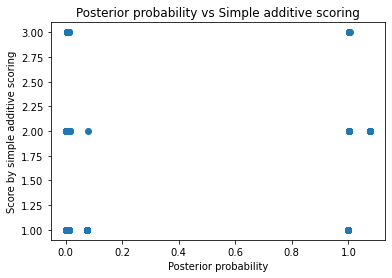

In [31]:
plt.scatter(posterior_array, score_array, s=None)
plt.ylabel('Score by simple additive scoring')
plt.xlabel('Posterior probability')
plt.title("Posterior probability vs Simple additive scoring")

Text(0.5, 1.0, 'Posterior probability vs cluster scoring')

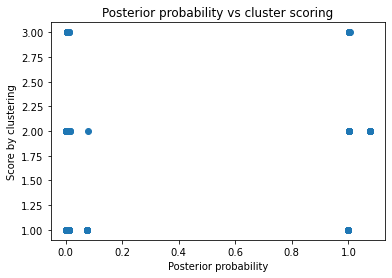

In [32]:
plt.scatter(posterior_array, bscore_array, s=None)
plt.xlabel("Posterior probability")
plt.ylabel("Score by clustering")
plt.title("Posterior probability vs cluster scoring")

# Prior vs Scoring

In [33]:
prior_array = []
Likelihood_array = []
score_array = []
for cluster in b_sorted_clusters:
    prior_array.append(cluster.prior)
    Likelihood_array.append((1/len(cluster.seq)))
    score_array.append(cluster.score)
for cluster in y_sorted_clusters:
    prior_array.append(cluster.prior)
    Likelihood_array.append((1/len(cluster.seq)))
    score_array.append(cluster.score)
print("Done")

Done


Text(0.5, 1.0, 'Prior probability vs cluster scoring')

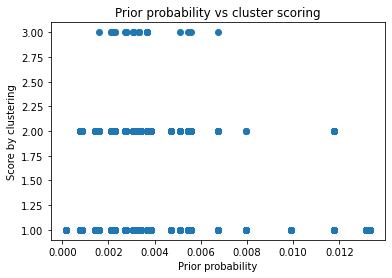

In [34]:
plt.scatter(prior_array, score_array, s=None)
plt.xlabel("Prior probability")
plt.ylabel("Score by clustering")
plt.title("Prior probability vs cluster scoring")

Text(0.5, 1.0, 'Likelihood vs cluster scoring')

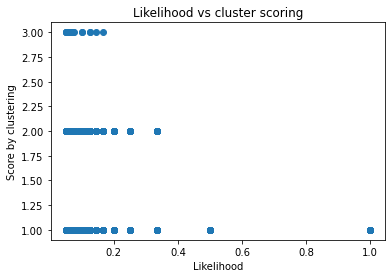

In [35]:
plt.scatter(Likelihood_array, score_array, s=None)
plt.xlabel("Likelihood")
plt.ylabel("Score by clustering")
plt.title("Likelihood vs cluster scoring")

# Weighted Sum vs Scoring

In [36]:
weighted_sum_array = []
score_array = []
for cluster in b_sorted_clusters:
    weighted_sum_array.append(calc_weighted_sum(cluster.indices, boundaries, matched_masses_b))
    score_array.append(cluster.score)
for cluster in y_sorted_clusters:
    weighted_sum_array.append(calc_weighted_sum(cluster.indices, boundaries, matched_masses_y))
    score_array.append(cluster.score)

Text(0.5, 1.0, 'Weighted sum vs cluster scoring')

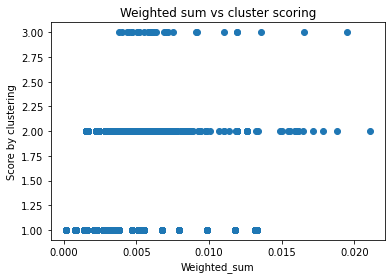

In [37]:
plt.scatter(weighted_sum_array, score_array, s=None)
plt.xlabel("Weighted_sum")
plt.ylabel("Score by clustering")
plt.title("Weighted sum vs cluster scoring")

# Probability of true positives

In [38]:
def calc_average(list):
    total = 0
    for x in list:
        total = total + x
    return total / len(list)

In [39]:
b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)


b_post_prob_array = []
b_score_array = []
y_post_prob_array = []
y_score_array = []
bad_clusters_prob = []
bad_clusters_score = []
ion = 'b'
for cluster in b_sorted_clusters:
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        b_post_prob_array.append(cluster.post_prob)
        b_score_array.append(cluster.score)
    else:
        bad_clusters_prob.append(cluster.post_prob)
        bad_clusters_score.append(cluster.score)
ion = 'y'
for cluster in y_sorted_clusters:
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        y_post_prob_array.append(cluster.post_prob)
        y_score_array.append(cluster.score)
    else:
        bad_clusters_prob.append(cluster.post_prob)
        bad_clusters_score.append(cluster.score)   

b_range = []
y_range = []
for i, x in enumerate(b_post_prob_array):
    b_range.append(i)
for i, x in enumerate(y_post_prob_array):
    y_range.append(i)
print('Average probability of b true positives in first spectrum:' ,calc_average(b_post_prob_array))
print('Average count of b true positives in first spectrum:' ,calc_average(b_score_array))
print('Average probability of y true positives in first spectrum:' ,calc_average(y_post_prob_array))
print('Average count of y true positives in first spectrum:' ,calc_average(y_score_array))
print('Average probability of false positives in the first spectrum:', calc_average(bad_clusters_prob))
print('Average count of false positives in the first spectrum:', calc_average(bad_clusters_score))
print('Number of true b positives', len(b_range))
print('Number of true y positives', len(y_range))
print('Number of bad clusters', len(bad_clusters_prob))

Average probability of b true positives in first spectrum: 0.005583985550872968
Average count of b true positives in first spectrum: 2.0


ZeroDivisionError: division by zero

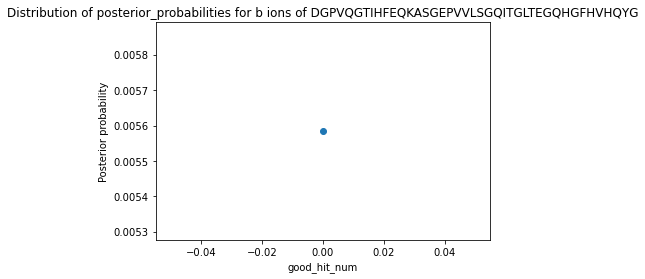

In [40]:
fig1, ax1 = plt.subplots()
ax1.scatter(x = b_range, y = b_post_prob_array)
plt.title("Distribution of posterior_probabilities for b ions of " + correct_sequence)
plt.xlabel("good_hit_num")
plt.ylabel("Posterior probability")
plt.show()

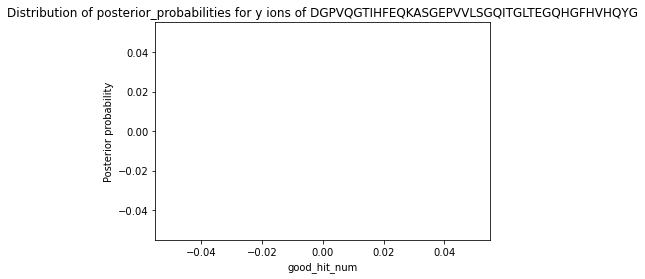

In [41]:
fig1, ax1 = plt.subplots()
ax1.scatter(x = y_range, y = y_post_prob_array)
plt.title("Distribution of posterior_probabilities for y ions of " + correct_sequence)
plt.xlabel("good_hit_num")
plt.ylabel("Posterior probability")
plt.show()

# Seed Location

Want to know where the good seeds rank compared to the bad seeds when sorted by score and sorted by posterior probability

Bottom is going to be enumerated array while vertical will be the score or posterior probability. The graph will be colored red or green depending on true or not

In [42]:
print("Collecting Data...")
b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
b_good_indexes = []
b_bad_indexes = []
b_good_cluster_prob = []
b_bad_cluster_prob = []
y_good_indexes = []
y_bad_indexes = []
y_good_cluster_prob = []
y_bad_cluster_prob = []
ion = 'b'
for i, cluster in enumerate(b_sorted_clusters):
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        b_good_indexes.append(i)
        b_good_cluster_prob.append(cluster.post_prob)
    else:
        b_bad_indexes.append(i)
        b_bad_cluster_prob.append(cluster.post_prob)
ion = 'y'
for i, cluster in enumerate(y_sorted_clusters):
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        y_good_indexes.append(i)
        y_good_cluster_prob.append(cluster.post_prob)
    else:
        y_bad_indexes.append(i)
        y_bad_cluster_prob.append(cluster.post_prob)
print('Done')

Done


No good hit found in the top 50 clusters


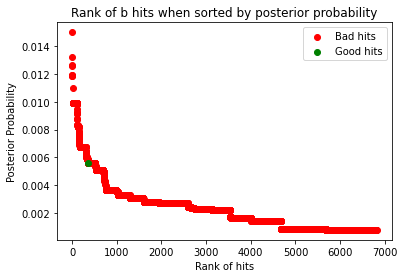

In [43]:
ion = 'b'
found = False
for i in range(0,50):
    target_cluster = b_sorted_clusters[i]
    assessment, _ = testing_utils.is_good_hit(target_cluster.seq, ion, correct_sequence)
    if assessment == True:
        print('Good hit found at:', i)
        found = True
if not found:
    print("No good hit found in the top 50 clusters")
plt.scatter(b_bad_indexes, b_bad_cluster_prob, color = 'r', label = 'Bad hits')
plt.scatter(b_good_indexes, b_good_cluster_prob, color = 'g', label = 'Good hits')
plt.title('Rank of b hits when sorted by posterior probability')
plt.xlabel('Rank of hits')
plt.ylabel('Posterior Probability')
plt.legend()

No good hit found in the top 50 clusters


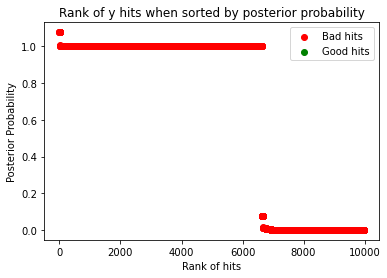

In [44]:
ion = 'y'
found = False
for i in range(0,50):
    target_cluster = y_sorted_clusters[i]
    assessment, _ = testing_utils.is_good_hit(target_cluster.seq, ion, correct_sequence)
    if assessment == True:
        print('Good hit found at:', i)
        found = True
if not found:
    print("No good hit found in the top 50 clusters")
plt.scatter(y_bad_indexes, y_bad_cluster_prob, color = 'r', label = 'Bad hits')
plt.scatter(y_good_indexes, y_good_cluster_prob, color = 'g', label = 'Good hits')
plt.title('Rank of y hits when sorted by posterior probability')
plt.xlabel('Rank of hits')
plt.ylabel('Posterior Probability')
plt.legend()

In [45]:
print("Collecting Data...")
b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('score', 'post_prob', 'pid', 'prior'), reverse = True)
y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('score', 'post_prob', 'pid', 'prior'), reverse = True)
b_good_indexes = []
b_bad_indexes = []
b_good_scores = []
b_bad_scores = []
y_good_indexes = []
y_bad_indexes = []
y_good_scores = []
y_bad_scores = []
ion = 'b'
for i, cluster in enumerate(b_sorted_clusters):
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        b_good_indexes.append(i)
        b_good_scores.append(cluster.score)
    else:
        b_bad_indexes.append(i)
        b_bad_scores.append(cluster.score)
ion = 'y'
for i, cluster in enumerate(y_sorted_clusters):
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        y_good_indexes.append(i)
        y_good_scores.append(cluster.score)
    else:
        y_bad_indexes.append(i)
        y_bad_scores.append(cluster.score)
print('Done')

Done


Good hit found at: 133


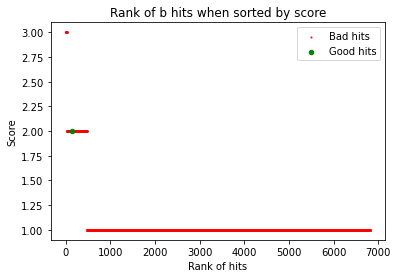

In [50]:
ion = 'b'
found = False
for i in range(0,134):
    target_cluster = b_sorted_clusters[i]
    assessment, _ = testing_utils.is_good_hit(target_cluster.seq, ion, correct_sequence)    
    if assessment == True:
        print('Good hit found at:', i)
        found = True
if found == False:
    print("No good hit found in the top 50 clusters")
plt.scatter(b_bad_indexes, b_bad_scores, color = 'r', label = 'Bad hits', s=1)
plt.scatter(b_good_indexes, b_good_scores, color = 'g', label = 'Good hits', s=20)
plt.title('Rank of b hits when sorted by score')
plt.xlabel('Rank of hits')
plt.ylabel('Score')
plt.legend()

cluster(post_prob=1.0064056441619698, prior=0.00546448087431694, score=3, pid=156, start=172, end=186, seq='GLGNKTYEHFNAMGK', mz=833.8908081054688, indices=[(172, 186, 'GLGNKTYEHFNAMGK', 833.8908081054688), (174, 186, 'GNKTYEHFNAMGK', 748.8368530273438), (186, 186, 'K', 74.06013488769531)])
cluster(post_prob=1.0030148516425854, prior=0.002136752136752137, score=3, pid=203, start=50, end=67, seq='VCPTEIIAFSDHAEDFRK', mz=1039.521484375, indices=[(50, 67, 'VCPTEIIAFSDHAEDFRK', 1039.521484375), (51, 67, 'CPTEIIAFSDHAEDFRK', 989.9853515625), (67, 67, 'K', 74.06013488769531)])
cluster(post_prob=1.0030148516425854, prior=0.002136752136752137, score=3, pid=27, start=733, end=750, seq='VTVTVLDVNDNRPEFTMK', mz=1039.521484375, indices=[(733, 750, 'VTVTVLDVNDNRPEFTMK', 1039.521484375), (734, 750, 'TVTVLDVNDNRPEFTMK', 989.9853515625), (750, 750, 'K', 74.06013488769531)])
cluster(post_prob=1.002849676216829, prior=0.003663003663003663, score=3, pid=157, start=411, end=428, seq='VVWTSEYDPLASNPGWKK', 

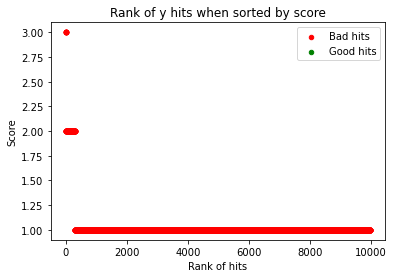

In [52]:
ion = 'y'
found = False
for i in range(0,10):
    target_cluster = y_sorted_clusters[i]
    print(target_cluster)
    assessment, _ = testing_utils.is_good_hit(target_cluster.seq, ion, correct_sequence)
    if assessment == True:
        print('Good hit found at:', i)
        found = True
if not found:
    print("No good hit found in the top 50 clusters")
plt.scatter(y_bad_indexes, y_bad_scores, color = 'r', label = 'Bad hits', s = 20)
plt.scatter(y_good_indexes, y_good_scores, color = 'g', label = 'Good hits', s = 20)
plt.title('Rank of y hits when sorted by score')
plt.xlabel('Rank of hits')
plt.ylabel('Score')
plt.legend()

# Distribution of size of seq vs weight

In [ ]:
size_array = []
weight_array = []
prot_size_array = []
prot_weight_array = []
for seq in correct_sequences:
    size_array.append(len(seq))
    weight_array.append(gen_spectra.get_precursor(seq))

In [ ]:
plt.scatter(size_array, weight_array)
plt.xlabel('Len of spectrummill result')
plt.ylabel('Weight of result')

In [ ]:
prot_size_array = []
prot_weight_array = []
for prot in db.proteins:
    target_prot = db.proteins[prot]
    if len(target_prot) != 0:
        target_prot = target_prot[0]
        seq = target_prot[1]
        prot_size_array.append(len(seq))
        prot_weight_array.append(gen_spectra.get_precursor(seq))
plt.scatter(prot_size_array, prot_weight_array)
plt.title('Size vs Weight of Proteome')
plt.xlabel('Len of Protein')
plt.ylabel('Weight of Protein')